In [ ]:
# -*- coding: utf-8 -*-
"""
A Digital Twin Framework for Adaptive Construction Logistics Planning
using Graph Neural Networks and Multi-Objective Optimization
"""

# Install required libraries
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118 -q
!pip install torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.1.0+cu118.html -q
!pip install torch_geometric -q
!pip install openmeteo-requests requests-cache retry-requests numpy pandas networkx scikit-learn deap matplotlib graphviz -q

# Import libraries
import openmeteo_requests
import requests_cache
import pandas as pd
from retry_requests import retry
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random
import time
from datetime import datetime, timedelta
import math
from math import sqrt
import copy
from functools import lru_cache
import hashlib
from dataclasses import dataclass, field
from typing import Dict, List, Tuple, Optional
import unittest

# PyTorch and PyG imports
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import SAGEConv, GATConv, DataParallel
import torch.nn.functional as F

# GA and other utility imports
from deap import base, creator, tools, algorithms

print("✅ Setup Complete. All libraries installed and imported.")

# --- Configuration Management (Enhanced for Journal Rigor) ---
@dataclass
class ExperimentConfig:
    """Centralized configuration for the entire experiment, enhanced for reproducibility."""
    site_graph: str = "large_scale"
    weather_aware: bool = True
    optimization_method: str = "NSGA2"
    vehicle_types: List[str] = field(default_factory=lambda: ['truck', 'forklift'])
    risk_tolerance: float = 0.5
    simulation_duration_hours: int = 168

    # --- NEW & EXPANDED PARAMETERS FOR JOURNAL-LEVEL EXPERIMENTS ---

    # Data Generation & Simulation Parameters
    num_training_samples: int = 20000       # Increased for robust GNN training
    num_simulation_runs: int = 200           # Crucial for statistical significance of results

    # Genetic Algorithm Parameters
    num_ga_generations: int = 100            # Increased for better convergence
    population_size: int = 100              # Increased for a broader search space

    # GNN Training Parameters
    gnn_epochs: int = 100                   # Increased for more thorough training
    gnn_early_stopping_patience: int = 10   # Prevents overfitting during training
    gnn_hidden_channels: int = 64
    batch_size: int = 32

# Global configuration instance
config = ExperimentConfig()

class RandomSeedManager:
    """Manager for reproducible results across all libraries."""
    @staticmethod
    def set_seeds(seed=42):
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(seed)

RandomSeedManager.set_seeds(42)

print("✅ Configuration and random seeds set.")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 82.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.6/875.6 kB 42.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 94.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 663.9/663.9 MB 2.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.9/417.9 MB 4.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 10.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 MB 30.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 MB 13.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.1/204.1 MB 8.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 MB 11.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_scatter/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_cluster/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-cluster'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:113: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_spline_conv/_version_cuda.so: undefined symbol: _ZN3c1017Registe

✅ Setup Complete. All libraries installed and imported.
✅ Configuration and random seeds set.


✅ Large-scale site graph created with 12 nodes and 21 edges.


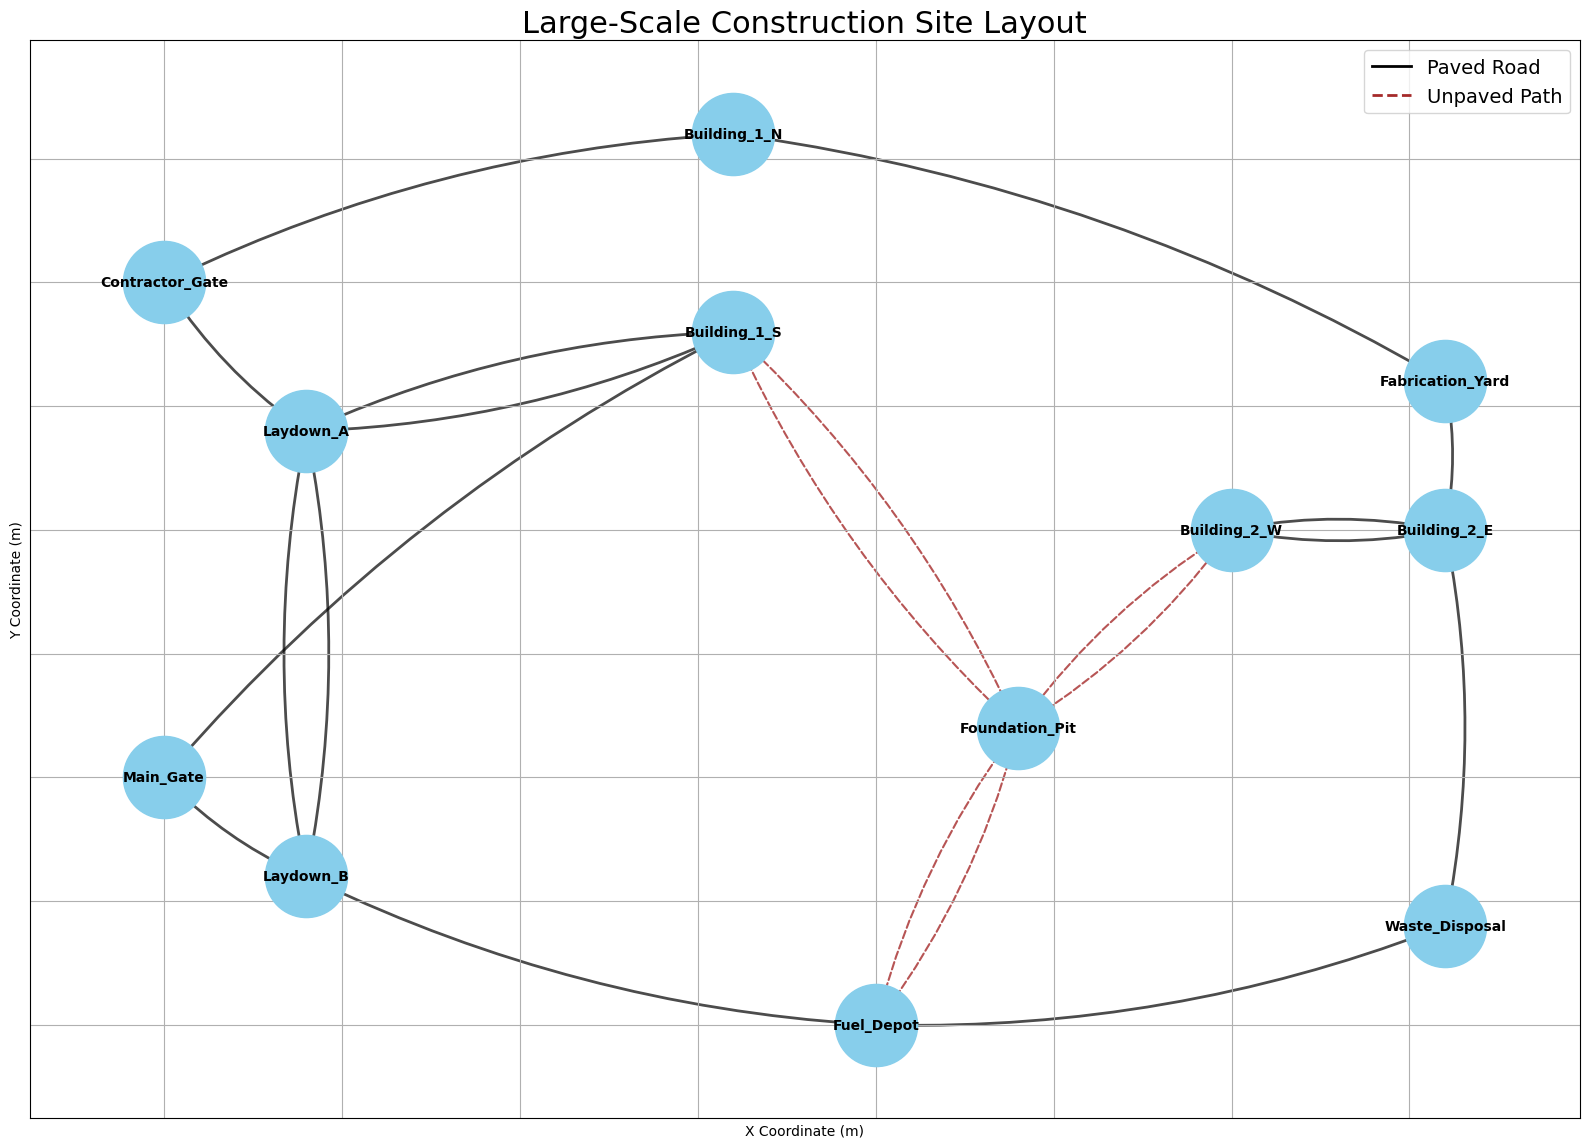

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import numpy as np
import random

class SiteGraphGenerator:
    """Generates realistic construction site graphs with specialized zones"""

    @staticmethod
    def create_large_scale_site_graph():
        """
        Creates a more complex and realistic construction site graph, representing a larger project
        with specialized zones and structured traffic flow.
        """
        G = nx.DiGraph()

        # Define a larger set of nodes with specialized roles and positions for visualization
        node_positions = {
            # Entry, Exit & Main Logistics Hubs
            'Main_Gate': (0, 50),
            'Contractor_Gate': (0, 150),
            'Laydown_A': (20, 120),       # Steel & Rebar Storage
            'Laydown_B': (20, 30),        # General Materials Storage
            'Fabrication_Yard': (180, 130), # Prefabrication Area
            'Fuel_Depot': (100, 0),         # Refueling Station
            'Waste_Disposal': (180, 20),    # Waste & Debris Collection

            # Work Zones (Representing multiple buildings or major areas)
            'Building_1_N': (80, 180),      # North side of Building 1
            'Building_1_S': (80, 140),      # South side of Building 1
            'Building_2_W': (150, 100),     # West side of Building 2
            'Building_2_E': (180, 100),     # East side of Building 2
            'Foundation_Pit': (120, 60),    # Major excavation area
        }

        for node, pos in node_positions.items():
            G.add_node(node, pos=pos)

        # Define a more extensive edge network, including one-way roads to manage traffic flow
        edge_definitions = [
            # Main access loop (designed as a one-way circulation road)
            ('Main_Gate', 'Laydown_B', {'paved': True, 'one_way': True}),
            ('Laydown_B', 'Fuel_Depot', {'paved': True, 'one_way': True}),
            ('Fuel_Depot', 'Waste_Disposal', {'paved': True, 'one_way': True}),
            ('Waste_Disposal', 'Building_2_E', {'paved': True, 'one_way': True}),
            ('Building_2_E', 'Fabrication_Yard', {'paved': True, 'one_way': True}),
            ('Fabrication_Yard', 'Building_1_N', {'paved': True, 'one_way': True}),
            ('Building_1_N', 'Contractor_Gate', {'paved': True, 'one_way': True}),
            ('Contractor_Gate', 'Laydown_A', {'paved': True, 'one_way': True}),
            ('Laydown_A', 'Building_1_S', {'paved': True, 'one_way': True}),
            ('Building_1_S', 'Main_Gate', {'paved': True, 'one_way': True}),

            # Two-way connector paths and access roads to work zones
            ('Laydown_A', 'Laydown_B', {'paved': True}),
            ('Building_1_S', 'Foundation_Pit', {'paved': False}), # Unpaved access to pit
            ('Foundation_Pit', 'Building_2_W', {'paved': False}), # Unpaved access to pit
            ('Building_2_W', 'Building_2_E', {'paved': True}),
            ('Building_1_S', 'Laydown_A', {'paved': True}), # Short-cut
            ('Fuel_Depot', 'Foundation_Pit', {'paved': False}), # Direct unpaved access
        ]

        for u, v, attrs in edge_definitions:
            pos_u, pos_v = np.array(node_positions[u]), np.array(node_positions[v])
            length = np.linalg.norm(pos_u - pos_v) * 1.5
            attrs['length'] = int(length)
            attrs['slope'] = random.randint(-4, 4)
            attrs['base_speed_limit'] = 10 if attrs.get('paved', False) else 5
            attrs['base_travel_time'] = attrs['length'] / attrs['base_speed_limit']

            G.add_edge(u, v, **attrs)
            if not attrs.get('one_way', False):
                rev_attrs = attrs.copy()
                rev_attrs['slope'] = -attrs['slope']
                G.add_edge(v, u, **rev_attrs)

        return G, node_positions

    @staticmethod
    def visualize_graph(graph, node_positions, title="Construction Site Layout"):
        # ... (visualization code remains unchanged) ...
        paved_edges = [edge for edge, attrs in graph.edges.items() if attrs.get('paved', False)]
        unpaved_edges = [edge for edge, attrs in graph.edges.items() if not attrs.get('paved', False)]

        plt.figure(figsize=(20, 14))
        nx.draw_networkx_nodes(graph, node_positions, node_size=3500, node_color='skyblue')
        nx.draw_networkx_labels(graph, node_positions, font_size=10, font_weight='bold')
        nx.draw_networkx_edges(graph, node_positions, edgelist=paved_edges,
                               width=2.0, alpha=0.7, edge_color='black',
                               connectionstyle='arc3,rad=0.1', arrowsize=20)
        nx.draw_networkx_edges(graph, node_positions, edgelist=unpaved_edges,
                               width=1.5, alpha=0.8, edge_color='brown', style='dashed',
                               connectionstyle='arc3,rad=0.1', arrowsize=20)
        plt.title(title, fontsize=22)
        plt.xlabel("X Coordinate (m)")
        plt.ylabel("Y Coordinate (m)")
        plt.grid(True)
        plt.legend(handles=[plt.Line2D([0], [0], color='black', lw=2, label='Paved Road'),
                             plt.Line2D([0], [0], color='brown', lw=2, ls='--', label='Unpaved Path')],
                   fontsize=14)
        plt.show()

# --- NEW: Two-Simulator Approach ---

class TrainingDataSimulator:
    """
    Generates synthetic logistics data based on a simplified, deterministic physics model.
    Its purpose is to create a large dataset for training the GNN surrogate model.
    This was previously the `SyntheticDataGenerator` class.
    """
    # Fleet & Simulation Configuration with Fuel
    VEHICLE_PROPERTIES = {
        'truck': {'base_speed_multiplier': 1.0, 'weather_sensitivity': 1.0, 'base_fuel_rate': 0.002},
        'forklift': {'base_speed_multiplier': 0.6, 'weather_sensitivity': 1.5, 'base_fuel_rate': 0.001}
    }
    SIMULATION_START_TIME = datetime.fromisoformat("2023-07-01T07:00:00")

    def __init__(self, site_graph, weather_df, scheduled_closures):
        self.site_graph = site_graph
        self.weather_df = weather_df
        self.scheduled_closures = scheduled_closures

    @staticmethod
    def get_weather_at_time(sim_time, weather_df):
        indexer = weather_df.index.get_indexer([sim_time], method='nearest')
        return weather_df.iloc[indexer[0]]

    def calculate_travel_time(self, edge_data, num_vehicles_on_edge, weather_features,
                                vehicle_type, current_time, soil_condition):
        """
        The simplified 'physics engine' for generating training data.
        It models mean time, variance, and fuel consumption deterministically.
        """
        # --- This is the original logic from your `calculate_ground_truth_travel` ---
        edge_key = (edge_data['start_node'], edge_data['end_node'])
        if edge_key in self.scheduled_closures:
            start_block, end_block = self.scheduled_closures[edge_key]
            if start_block <= current_time <= end_block:
                return float('inf'), 0.0, 0.0

        vehicle_props = self.VEHICLE_PROPERTIES[vehicle_type]
        base_time = edge_data['base_travel_time'] / vehicle_props['base_speed_multiplier']
        congestion_factor = 1.0 + 0.2 * (num_vehicles_on_edge ** 2)
        weather_and_soil_factor = 1.0
        variance_factor = 0.05

        rain_idx = int(weather_features['rain_intensity'])
        heat_idx = int(weather_features['heat_stress'])
        soil_idx = int(soil_condition)

        if rain_idx > 0:
            weather_and_soil_factor += [0, 0.1, 0.4, 0.7][rain_idx] * vehicle_props['weather_sensitivity']
            variance_factor += [0, 0.1, 0.3, 0.2][rain_idx]
        if heat_idx > 0:
            weather_and_soil_factor += [0, 0.05, 0.15][heat_idx]
            variance_factor += [0, 0.05, 0.1][heat_idx]
        if not edge_data['paved'] and soil_idx > 0:
            weather_and_soil_factor *= [1.0, 1.5, 3.0][soil_idx]
            variance_factor += [0, 0.2, 0.4][soil_idx]

        mean_time = base_time * congestion_factor * weather_and_soil_factor
        final_mean_time = max(mean_time, base_time)
        variance = (base_time * variance_factor)**2

        fuel_efficiency_factor = 1.0
        if edge_data['slope'] > 0:
            fuel_efficiency_factor += edge_data['slope'] * 0.15
        if not edge_data['paved'] and soil_idx > 0:
            fuel_efficiency_factor *= [1.0, 1.8, 3.5][soil_idx]

        fuel_consumed = vehicle_props['base_fuel_rate'] * final_mean_time * fuel_efficiency_factor
        return final_mean_time, variance, fuel_consumed

    def generate_synthetic_data(self, num_samples=150):
        # ... (This is the original `generate_synthetic_data` method, just calling the renamed `calculate_travel_time`)
        print(f"🚀 Starting synthetic data generation for GNN training ({num_samples} samples)...")
        edge_traversal_log = []
        for i in range(num_samples):
            u, v, edge_attrs = random.choice(list(self.site_graph.edges(data=True)))
            sim_time = self.SIMULATION_START_TIME + timedelta(hours=random.uniform(0, config.simulation_duration_hours))
            weather_now = self.get_weather_at_time(sim_time, self.weather_df)
            vehicle_type = random.choice(['truck', 'forklift'])
            num_on_edge = random.randint(0, 2)
            soil = 0
            if not edge_attrs['paved']:
                recent_weather = self.weather_df[sim_time - timedelta(hours=3):sim_time]
                if not recent_weather.empty:
                    max_recent_rain = recent_weather['rain_intensity'].max()
                    if max_recent_rain >= 2: soil = 2
                    elif max_recent_rain == 1: soil = 1

            edge_attrs_with_nodes = {**edge_attrs, 'start_node': u, 'end_node': v}
            mean_time, variance, fuel = self.calculate_travel_time(
                edge_attrs_with_nodes, num_on_edge, weather_now, vehicle_type, sim_time, soil
            )

            if mean_time != float('inf'):
                log_entry = {
                    'edge_start_node': u, 'edge_end_node': v,
                    'mean_travel_time': mean_time,
                    'variance': variance,
                    'fuel_consumed': fuel,
                    'time_of_day': sim_time.hour + sim_time.minute / 60.0,
                    'num_vehicles_on_edge': num_on_edge,
                    **weather_now.to_dict(),
                    'soil_condition': soil,
                    'vehicle_type_truck': 1 if vehicle_type == 'truck' else 0
                }
                edge_traversal_log.append(log_entry)

        dataset_df = pd.DataFrame(edge_traversal_log)
        print(f"✅ Training data generation complete. Generated {len(dataset_df)} records.")
        return dataset_df

class GroundTruthSimulator:
    """
    Represents the high-fidelity 'ground truth' of the site. Its physics are intentionally
    more complex and stochastic than the TrainingDataSimulator.
    """
    VEHICLE_PROPERTIES = TrainingDataSimulator.VEHICLE_PROPERTIES

    def __init__(self, site_graph, weather_df, scheduled_closures):
        self.site_graph = site_graph
        self.weather_df = weather_df
        self.scheduled_closures = scheduled_closures

    def calculate_ground_truth_travel(self, edge_data, num_vehicles_on_edge, weather_features,
                                    vehicle_type, current_time, soil_condition):
        """
        A more complex physics engine for ground truth validation. Introduces non-linear congestion,
        acceleration penalties, and stochastic noise.
        """
        edge_key = (edge_data['start_node'], edge_data['end_node'])
        if edge_key in self.scheduled_closures:
            start_block, end_block = self.scheduled_closures[edge_key]
            if start_block <= current_time <= end_block:
                return float('inf'), 0.0, 0.0

        vehicle_props = self.VEHICLE_PROPERTIES[vehicle_type]
        base_time = edge_data['base_travel_time'] / vehicle_props['base_speed_multiplier']

        # Non-linear congestion and acceleration/deceleration penalty
        congestion_factor = 1.0 + 0.3 * (num_vehicles_on_edge ** 1.5)
        accel_decel_penalty = 5.0 # Constant 5 seconds for starting/stopping

        weather_and_soil_factor = 1.0
        rain_idx = int(weather_features['rain_intensity'])
        heat_idx = int(weather_features['heat_stress'])
        soil_idx = int(soil_condition)

        if rain_idx > 0:
            weather_and_soil_factor += [0, 0.15, 0.45, 0.8][rain_idx] * vehicle_props['weather_sensitivity']
        if heat_idx > 0:
            weather_and_soil_factor += [0, 0.08, 0.18][heat_idx]
        if not edge_data['paved'] and soil_idx > 0:
            weather_and_soil_factor *= [1.0, 1.6, 3.2][soil_idx]

        mean_time = (base_time * congestion_factor * weather_and_soil_factor) + accel_decel_penalty

        # Introduce stochastic noise using a log-normal distribution for realism
        noise = np.random.lognormal(mean=0, sigma=0.25) # Multiplicative noise centered at 1.0
        final_mean_time = max(mean_time * noise, base_time)
        variance = (base_time * 0.2)**2

        fuel_efficiency_factor = 1.0
        if edge_data['slope'] > 0:
            fuel_efficiency_factor += edge_data['slope'] * 0.18
        if not edge_data['paved'] and soil_idx > 0:
            fuel_efficiency_factor *= [1.0, 2.0, 3.8][soil_idx]

        fuel_consumed = vehicle_props['base_fuel_rate'] * final_mean_time * fuel_efficiency_factor * (1 + 0.1 * num_vehicles_on_edge)

        return final_mean_time, variance, fuel_consumed

# --- Initialization and Schedule Definition ---
site_graph, node_positions = SiteGraphGenerator.create_large_scale_site_graph()

SCHEDULED_CLOSURES = {
    ('Foundation_Pit', 'Building_2_W'): (datetime.fromisoformat("2023-07-01T13:00:00"), datetime.fromisoformat("2023-07-01T15:00:00")),
    ('Building_2_W', 'Foundation_Pit'): (datetime.fromisoformat("2023-07-01T13:00:00"), datetime.fromisoformat("2023-07-01T15:00:00"))
}

print(f"✅ Large-scale site graph created with {site_graph.number_of_nodes()} nodes and {site_graph.number_of_edges()} edges.")
SiteGraphGenerator.visualize_graph(site_graph, node_positions, "Large-Scale Construction Site Layout")

✅ Weather data fetched and engineered successfully.

--- Sample of Weather DataFrame with Engineered Features ---
                     temperature_2m  rain  wind_speed_10m  rain_intensity  \
2023-07-01 00:00:00       17.356501   0.0       19.862083               0   
2023-07-01 01:00:00       17.456501   0.0       18.504139               0   
2023-07-01 02:00:00       17.506500   0.0       18.089775               0   
2023-07-01 03:00:00       17.406500   0.0       18.919704               0   
2023-07-01 04:00:00       17.206501   0.1       17.462782               1   

                     wind_hazard  heat_stress  
2023-07-01 00:00:00            1            0  
2023-07-01 01:00:00            1            0  
2023-07-01 02:00:00            1            0  
2023-07-01 03:00:00            1            0  
2023-07-01 04:00:00            1            0  

--- Visualizing Engineered Weather Features ---


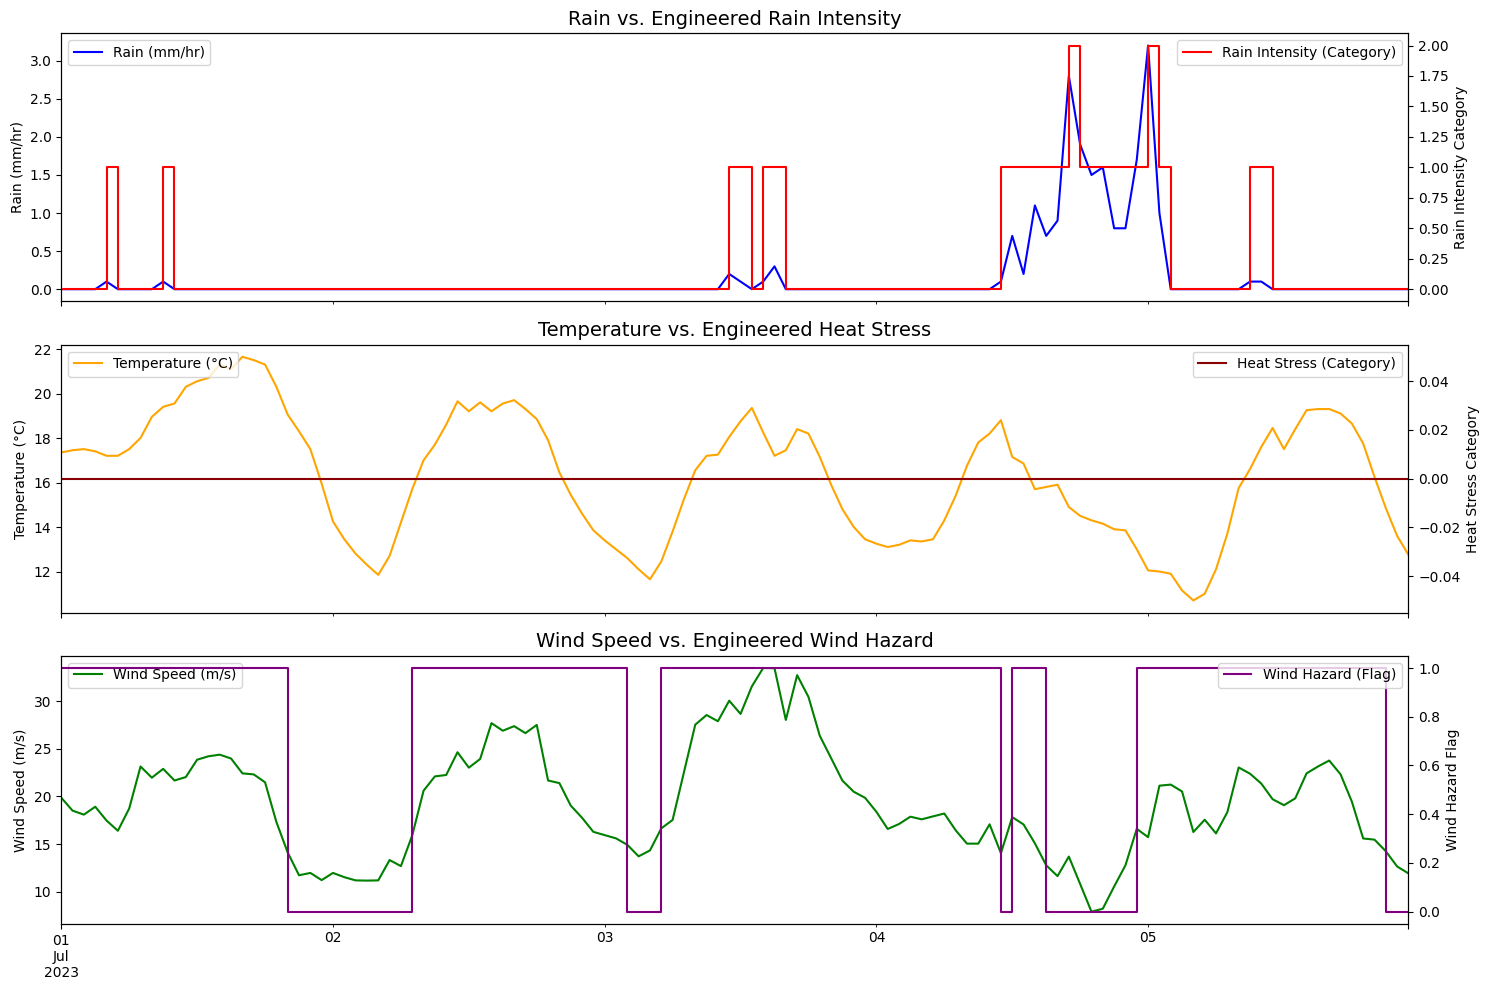

In [ ]:
import openmeteo_requests
import requests_cache
import pandas as pd
from retry_requests import retry
import matplotlib.pyplot as plt
import numpy as np # Ensure numpy is imported here as well

class WeatherDataManager:
    """
    Manages fetching, processing, and feature engineering of weather data.
    This class serves as the data source for both the training simulator and the
    GNN's real-time feature inputs.
    """

    def __init__(self):
        self.cache_session = requests_cache.CachedSession('.cache', expire_after=-1)
        self.retry_session = retry(self.cache_session, retries=5, backoff_factor=0.2)
        self.openmeteo = openmeteo_requests.Client(session=self.retry_session)

    def get_weather_data(self, latitude, longitude, start_date, end_date):
        """
        Fetches historical hourly weather data from the Open-Meteo API.
        It uses caching to avoid re-downloading data during development and experiments.
        """
        url = "https://archive-api.open-meteo.com/v1/archive"
        params = {
            "latitude": latitude,
            "longitude": longitude,
            "start_date": start_date,
            "end_date": end_date,
            "hourly": ["temperature_2m", "rain", "wind_speed_10m"]
        }
        responses = self.openmeteo.weather_api(url, params=params)
        response = responses[0]
        hourly = response.Hourly()
        hourly_data = {
            "temperature_2m": hourly.Variables(0).ValuesAsNumpy(),
            "rain": hourly.Variables(1).ValuesAsNumpy(),
            "wind_speed_10m": hourly.Variables(2).ValuesAsNumpy(),
        }
        df = pd.DataFrame(data=hourly_data)
        start = pd.to_datetime(hourly.Time(), unit="s")
        end = pd.to_datetime(hourly.TimeEnd(), unit="s")
        interval = pd.Timedelta(seconds=hourly.Interval())
        df.index = pd.date_range(start=start, end=end, freq=interval, inclusive="left")
        df = df.astype({'temperature_2m': 'float32', 'rain': 'float32', 'wind_speed_10m': 'float32'})
        return df

    @staticmethod
    def feature_engineer_weather(df):
        """
        Adds engineered, construction-relevant features to the raw weather dataframe.
        """
        df['rain_intensity'] = pd.cut(df['rain'],
                                      bins=[-np.inf, 0.1, 2.5, 7.6, np.inf],
                                      labels=[0, 1, 2, 3],
                                      right=False).astype(int)
        df['wind_hazard'] = (df['wind_speed_10m'] > 15).astype(int)
        df['heat_stress'] = pd.cut(df['temperature_2m'],
                                   bins=[-np.inf, 28, 32, np.inf],
                                   labels=[0, 1, 2],
                                   right=False).astype(int)
        return df

    @staticmethod
    def get_weather_at_time(sim_time, weather_df):
        """
        CORRECTED: Robustly retrieves weather features for a given timestamp.
        Uses nearest-neighbor lookup via get_indexer, which accepts the 'method' argument.
        """
        if weather_df.index.empty:
            # Handle case where weather_df is empty to prevent errors
            return pd.Series(dtype='float64')

        # get_indexer is the correct method for this operation.
        indexer = weather_df.index.get_indexer([sim_time], method='nearest')

        # get_indexer returns an array, so we take the first element.
        return weather_df.iloc[indexer[0]]

    @staticmethod
    def visualize_weather_features(weather_df, days=5):
        """Visualize the raw data alongside the engineered categorical features."""
        end_time = weather_df.index[0] + pd.Timedelta(days=days)
        sample_data = weather_df.loc[weather_df.index < end_time]

        fig, axes = plt.subplots(3, 1, figsize=(15, 10), sharex=True)

        # Plot 1: Rain and Rain Intensity
        ax1_twin = axes[0].twinx()
        sample_data['rain'].plot(ax=axes[0], color='blue', label='Rain (mm/hr)', style='-')
        sample_data['rain_intensity'].plot(ax=ax1_twin, color='red', label='Rain Intensity (Category)', drawstyle='steps-post')
        axes[0].set_ylabel("Rain (mm/hr)")
        ax1_twin.set_ylabel("Rain Intensity Category")
        axes[0].legend(loc='upper left')
        ax1_twin.legend(loc='upper right')
        axes[0].set_title("Rain vs. Engineered Rain Intensity", fontsize=14)

        # Plot 2: Temperature and Heat Stress
        ax2_twin = axes[1].twinx()
        sample_data['temperature_2m'].plot(ax=axes[1], color='orange', label='Temperature (°C)')
        sample_data['heat_stress'].plot(ax=ax2_twin, color='darkred', label='Heat Stress (Category)', drawstyle='steps-post')
        axes[1].set_ylabel("Temperature (°C)")
        ax2_twin.set_ylabel("Heat Stress Category")
        axes[1].legend(loc='upper left')
        ax2_twin.legend(loc='upper right')
        axes[1].set_title("Temperature vs. Engineered Heat Stress", fontsize=14)

        # Plot 3: Wind and Wind Hazard
        ax3_twin = axes[2].twinx()
        sample_data['wind_speed_10m'].plot(ax=axes[2], color='green', label='Wind Speed (m/s)')
        sample_data['wind_hazard'].plot(ax=ax3_twin, color='purple', label='Wind Hazard (Flag)', drawstyle='steps-post')
        axes[2].set_ylabel("Wind Speed (m/s)")
        ax3_twin.set_ylabel("Wind Hazard Flag")
        axes[2].legend(loc='upper left')
        ax3_twin.legend(loc='upper right')
        axes[2].set_title("Wind Speed vs. Engineered Wind Hazard", fontsize=14)

        plt.xlabel("Date", fontsize=12)
        plt.tight_layout()
        plt.show()

# --- Execution ---
weather_manager = WeatherDataManager()
weather_df = weather_manager.get_weather_data(latitude=51.5085, longitude=-0.1257,
                                              start_date="2023-07-01", end_date="2023-07-31")
weather_df = WeatherDataManager.feature_engineer_weather(weather_df)

print("✅ Weather data fetched and engineered successfully.")
print("\n--- Sample of Weather DataFrame with Engineered Features ---")
print(weather_df.head())

# Visualize the engineered features
print("\n--- Visualizing Engineered Weather Features ---")
WeatherDataManager.visualize_weather_features(weather_df, days=5)

In [ ]:
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta

# --- NEW: Two-Simulator Approach ---

class TrainingDataSimulator:
    """
    Generates synthetic logistics data based on a simplified, deterministic physics model.
    Its purpose is to create a large dataset for training the GNN surrogate model.
    """
    VEHICLE_PROPERTIES = {
        'truck': {'base_speed_multiplier': 1.0, 'weather_sensitivity': 1.0, 'base_fuel_rate': 0.002},
        'forklift': {'base_speed_multiplier': 0.6, 'weather_sensitivity': 1.5, 'base_fuel_rate': 0.001}
    }
    SIMULATION_START_TIME = datetime.fromisoformat("2023-07-01T07:00:00")

    def __init__(self, site_graph, weather_df, scheduled_closures):
        self.site_graph = site_graph
        self.weather_df = weather_df
        self.scheduled_closures = scheduled_closures
        self.weather_manager = WeatherDataManager() # Instantiate for access to methods

    def calculate_travel_time(self, edge_data, num_vehicles_on_edge, weather_features,
                                vehicle_type, current_time, soil_condition):
        """
        The simplified 'physics engine' for generating training data.
        It models mean time, variance, and fuel consumption deterministically based on simple rules.
        """
        edge_key = (edge_data['start_node'], edge_data['end_node'])
        if edge_key in self.scheduled_closures:
            start_block, end_block = self.scheduled_closures[edge_key]
            if start_block <= current_time <= end_block:
                return float('inf'), 0.0, 0.0

        vehicle_props = self.VEHICLE_PROPERTIES[vehicle_type]
        base_time = edge_data['base_travel_time'] / vehicle_props['base_speed_multiplier']
        congestion_factor = 1.0 + 0.2 * (num_vehicles_on_edge ** 2)
        weather_and_soil_factor = 1.0
        variance_factor = 0.05

        rain_idx = int(weather_features['rain_intensity'])
        heat_idx = int(weather_features['heat_stress'])
        soil_idx = int(soil_condition)

        if rain_idx > 0:
            weather_and_soil_factor += [0, 0.1, 0.4, 0.7][rain_idx] * vehicle_props['weather_sensitivity']
            variance_factor += [0, 0.1, 0.3, 0.2][rain_idx]
        if heat_idx > 0:
            weather_and_soil_factor += [0, 0.05, 0.15][heat_idx]
            variance_factor += [0, 0.05, 0.1][heat_idx]
        if not edge_data['paved'] and soil_idx > 0:
            weather_and_soil_factor *= [1.0, 1.5, 3.0][soil_idx]
            variance_factor += [0, 0.2, 0.4][soil_idx]

        mean_time = base_time * congestion_factor * weather_and_soil_factor
        final_mean_time = max(mean_time, base_time)
        variance = (base_time * variance_factor)**2

        fuel_efficiency_factor = 1.0
        if edge_data['slope'] > 0:
            fuel_efficiency_factor += edge_data['slope'] * 0.15
        if not edge_data['paved'] and soil_idx > 0:
            fuel_efficiency_factor *= [1.0, 1.8, 3.5][soil_idx]

        fuel_consumed = vehicle_props['base_fuel_rate'] * final_mean_time * fuel_efficiency_factor
        return final_mean_time, variance, fuel_consumed

    def generate_synthetic_data(self, num_samples=150):
        """Generates a large, varied dataset for GNN training."""
        print(f"🚀 Starting synthetic data generation for GNN training ({num_samples} samples)...")
        edge_traversal_log = []

        for i in range(num_samples):
            if (i + 1) % 5000 == 0:
                print(f"   ...generated {i+1}/{num_samples} samples...")

            u, v, edge_attrs = random.choice(list(self.site_graph.edges(data=True)))
            sim_time = self.SIMULATION_START_TIME + timedelta(hours=random.uniform(0, config.simulation_duration_hours))
            weather_now = self.weather_manager.get_weather_at_time(sim_time, self.weather_df)
            vehicle_type = random.choice(['truck', 'forklift'])
            num_on_edge = random.randint(0, 2)
            soil = 0
            if not edge_attrs['paved']:
                recent_weather = self.weather_df[sim_time - timedelta(hours=3):sim_time]
                if not recent_weather.empty:
                    max_recent_rain = recent_weather['rain_intensity'].max()
                    if max_recent_rain >= 2: soil = 2
                    elif max_recent_rain == 1: soil = 1

            edge_attrs_with_nodes = {**edge_attrs, 'start_node': u, 'end_node': v}
            mean_time, variance, fuel = self.calculate_travel_time(
                edge_attrs_with_nodes, num_on_edge, weather_now, vehicle_type, sim_time, soil
            )

            if mean_time != float('inf'):
                log_entry = {
                    'edge_start_node': u, 'edge_end_node': v, 'mean_travel_time': mean_time,
                    'variance': variance, 'fuel_consumed': fuel,
                    'time_of_day': sim_time.hour + sim_time.minute / 60.0,
                    'num_vehicles_on_edge': num_on_edge, **weather_now.to_dict(),
                    'soil_condition': soil, 'vehicle_type_truck': 1 if vehicle_type == 'truck' else 0
                }
                edge_traversal_log.append(log_entry)

        dataset_df = pd.DataFrame(edge_traversal_log)
        print(f"✅ Training data generation complete. Generated {len(dataset_df)} records.")
        return dataset_df

class GroundTruthSimulator:
    """
    Represents the high-fidelity "ground truth" of the site. Its physics are intentionally
    more complex and stochastic than the TrainingDataSimulator to represent the gap between a
    simplified model and reality.
    """
    VEHICLE_PROPERTIES = TrainingDataSimulator.VEHICLE_PROPERTIES

    def __init__(self, site_graph, weather_df, scheduled_closures):
        self.site_graph = site_graph
        self.weather_df = weather_df
        self.scheduled_closures = scheduled_closures
        self.weather_manager = WeatherDataManager()

    def calculate_ground_truth_travel(self, edge_data, num_vehicles_on_edge, weather_features,
                                    vehicle_type, current_time, soil_condition):
        """
        A more complex physics engine for ground truth validation. Introduces non-linear congestion,
        acceleration penalties, and stochastic noise.
        """
        edge_key = (edge_data['start_node'], edge_data['end_node'])
        if edge_key in self.scheduled_closures:
            start_block, end_block = self.scheduled_closures[edge_key]
            if start_block <= current_time <= end_block:
                return float('inf'), 0.0, 0.0

        vehicle_props = self.VEHICLE_PROPERTIES[vehicle_type]
        base_time = edge_data['base_travel_time'] / vehicle_props['base_speed_multiplier']

        # Non-linear congestion and acceleration/deceleration penalty
        congestion_factor = 1.0 + 0.3 * (num_vehicles_on_edge ** 1.5)
        accel_decel_penalty = 5.0 # Constant 5 seconds for starting/stopping

        weather_and_soil_factor = 1.0
        rain_idx = int(weather_features['rain_intensity'])
        heat_idx = int(weather_features['heat_stress'])
        soil_idx = int(soil_condition)

        if rain_idx > 0:
            weather_and_soil_factor += [0, 0.15, 0.45, 0.8][rain_idx] * vehicle_props['weather_sensitivity']
        if heat_idx > 0:
            weather_and_soil_factor += [0, 0.08, 0.18][heat_idx]
        if not edge_data['paved'] and soil_idx > 0:
            weather_and_soil_factor *= [1.0, 1.6, 3.2][soil_idx]

        mean_time = (base_time * congestion_factor * weather_and_soil_factor) + accel_decel_penalty

        # Introduce stochastic noise using a log-normal distribution for realism
        noise = np.random.lognormal(mean=0, sigma=0.25) # Multiplicative noise centered at 1.0
        final_mean_time = max(mean_time * noise, base_time)
        variance = (base_time * 0.2)**2

        fuel_efficiency_factor = 1.0
        if edge_data['slope'] > 0:
            fuel_efficiency_factor += edge_data['slope'] * 0.18
        if not edge_data['paved'] and soil_idx > 0:
            fuel_efficiency_factor *= [1.0, 2.0, 3.8][soil_idx]

        fuel_consumed = vehicle_props['base_fuel_rate'] * final_mean_time * fuel_efficiency_factor * (1 + 0.1 * num_vehicles_on_edge)

        return final_mean_time, variance, fuel_consumed

# --- Execution: Generate training data and instantiate simulators ---

# Generate the large dataset for training the GNN
training_data_generator = TrainingDataSimulator(site_graph, weather_df, SCHEDULED_CLOSURES)
dataset_df = training_data_generator.generate_synthetic_data(num_samples=config.num_training_samples)

print("\n--- Sample of Generated Dataset with Fuel ---")
display(dataset_df[['edge_start_node', 'mean_travel_time', 'fuel_consumed', 'soil_condition']].head())

# Instantiate the ground truth simulator for use in the main experiment loop
ground_truth_sim = GroundTruthSimulator(site_graph, weather_df, SCHEDULED_CLOSURES)
print("\n✅ Ground truth simulator is ready.")

🚀 Starting synthetic data generation for GNN training (20000 samples)...
   ...generated 5000/20000 samples...
   ...generated 10000/20000 samples...
   ...generated 15000/20000 samples...
   ...generated 20000/20000 samples...
✅ Training data generation complete. Generated 19973 records.

--- Sample of Generated Dataset with Fuel ---


,edge_start_node,mean_travel_time,fuel_consumed,soil_condition
0,Foundation_Pit,40.500000,0.145800,1
1,Foundation_Pit,31.333333,0.031333,0
2,Building_2_W,24.750000,0.129195,1
3,Building_1_S,9.400000,0.018800,0
4,Building_1_N,21.333333,0.021333,0



✅ Ground truth simulator is ready.


In [ ]:
import torch
from torch.utils.data import random_split
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GATConv
import torch.nn.functional as F
import pandas as pd

class EdgePredictorGAT(torch.nn.Module):
    """
    A Graph Neural Network model using Graph Attention (GAT) layers to predict
    the mean and variance of travel time for edges in the site graph.
    The GNN acts as a fast surrogate for the complex site physics.
    """
    def __init__(self, node_channels, edge_channels, hidden_channels):
        super().__init__()
        self.gat1 = GATConv(node_channels, hidden_channels, heads=2, concat=True)
        self.gat2 = GATConv(hidden_channels * 2, hidden_channels, heads=1, concat=False)

        # The MLP takes the concatenated embeddings of the start node, end node, and edge features
        mlp_input_dim = 2 * hidden_channels + edge_channels

        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(mlp_input_dim, hidden_channels),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_channels, 2) # Output: [mean, log_variance]
        )

    def forward(self, x, edge_index, edge_attr, edge_label_index):
        """Forward pass for a batch of graph samples."""
        # Get node embeddings
        x = F.elu(self.gat1(x, edge_index))
        x = self.gat2(x, edge_index)

        # Select embeddings for the start and end nodes of the target edges
        start_node_emb = x[edge_label_index[0]]
        end_node_emb = x[edge_label_index[1]]

        # In a batched scenario from DataLoader, edge_attr needs careful handling.
        # We assume the edge_attr for a specific graph in the batch is implicitly
        # aligned with its edge_label_index.
        # For batching, PyG repeats node features but concatenates edge features.
        # This simplified approach works for full-graph prediction scenarios like ours.

        # Find the single edge_attr vector corresponding to each edge_label_index pair.
        # This is a bit complex in PyG's batching, so we make a simplifying assumption
        # that the dynamic part of edge_attr is uniform across the graph for one sample.
        # We extract the attributes for the target edges directly.

        # A more robust (but slower) method would involve iterating and matching.
        # Given our data generation, we can rely on a simpler extraction.
        # Let's find the correct edge attributes for the labeled edges.
        edge_features_list = []
        for i in range(edge_label_index.shape[1]):
            u, v = edge_label_index[0, i], edge_label_index[1, i]
            # Find the corresponding edge in the full edge_index
            mask = (edge_index[0] == u) & (edge_index[1] == v)
            if mask.any():
                idx = mask.nonzero(as_tuple=True)[0][0]
                edge_features_list.append(edge_attr[idx])
            else:
                # Should not happen in our case, but as a fallback:
                edge_features_list.append(torch.zeros_like(edge_attr[0]))

        edge_features = torch.stack(edge_features_list)

        combined = torch.cat([start_node_emb, end_node_emb, edge_features], dim=1)

        output = self.mlp(combined)
        mean, log_var = output[:, 0], output[:, 1]
        var = torch.exp(log_var)  # Ensure variance is positive
        return mean, var

class GNNTrainer:
    """Handles GNN training with train/val split, early stopping, and caching."""

    def __init__(self, site_graph, dataset_df):
        self.site_graph = site_graph
        self.dataset_df = dataset_df
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        print(f"GNN Trainer initialized on device: {self.device}")

    def prepare_graph_data(self):
        """Prepare static graph structure and features."""
        node_mapping = {name: i for i, name in enumerate(self.site_graph.nodes())}

        static_edge_features = [
            [d['length'], d['slope'], float(d.get('paved', False))]
            for _, _, d in self.site_graph.edges(data=True)
        ]
        static_edge_features = torch.tensor(static_edge_features, dtype=torch.float)

        edge_index = torch.tensor(list(zip(*[
            (node_mapping[u], node_mapping[v]) for u, v in self.site_graph.edges()
        ])), dtype=torch.long)

        return node_mapping, static_edge_features, edge_index

    def create_pyg_dataset(self, weather_aware=True):
        """Create PyTorch Geometric dataset from the pandas DataFrame."""
        node_mapping, static_edge_features, edge_index = self.prepare_graph_data()
        pyg_data_list = []

        if weather_aware:
            dynamic_features_keys = ['time_of_day', 'num_vehicles_on_edge', 'rain_intensity',
                                     'heat_stress', 'wind_hazard', 'soil_condition', 'vehicle_type_truck']
        else:
            dynamic_features_keys = ['time_of_day', 'num_vehicles_on_edge', 'vehicle_type_truck']

        for _, record in self.dataset_df.iterrows():
            dynamic_feats = [float(record[key]) for key in dynamic_features_keys]

            dynamic_edge_features = torch.tensor(dynamic_feats, dtype=torch.float).repeat(
                self.site_graph.number_of_edges(), 1)

            edge_attr = torch.cat([static_edge_features, dynamic_edge_features], dim=1)

            y = torch.tensor([[record['mean_travel_time'], record['variance']]], dtype=torch.float)

            u, v = node_mapping[record['edge_start_node']], node_mapping[record['edge_end_node']]

            data = Data(
                x=torch.eye(len(node_mapping)),
                edge_index=edge_index,
                edge_attr=edge_attr,
                y=y,
                edge_label_index=torch.tensor([[u],[v]], dtype=torch.long)
            )
            pyg_data_list.append(data)

        return pyg_data_list, node_mapping, static_edge_features, edge_index

    def train_gnn_model(self, gnn_type='GAT', weather_aware=True):
        """
        Trains a GNN model with a proper validation loop and early stopping for robustness.
        """
        print(f"\n--- Training GNN Model (Variant: {gnn_type}, Weather-Aware: {weather_aware}) ---")

        pyg_data_list, node_mapping, static_edge_features, edge_index = self.create_pyg_dataset(weather_aware)

        if not pyg_data_list:
            print("❌ No data available for training! Creating dummy model...")
            class DummyModel(torch.nn.Module):
                def forward(self, x, edge_index, edge_attr, edge_label_index):
                    return torch.tensor([60.0]), torch.tensor([10.0])
            return DummyModel(), node_mapping, static_edge_features, edge_index

        # Train/Validation Split (80/20)
        train_size = int(0.8 * len(pyg_data_list))
        val_size = len(pyg_data_list) - train_size
        train_dataset, val_dataset = random_split(pyg_data_list, [train_size, val_size])

        train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=config.batch_size)

        edge_channels = pyg_data_list[0].edge_attr.shape[1]
        node_channels = len(node_mapping)

        model = EdgePredictorGAT(node_channels, edge_channels, config.gnn_hidden_channels)
        model = model.to(self.device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

        def nll_loss(y_true_mean, y_true_var, y_pred_mean, y_pred_var):
            epsilon = 1e-6
            loss = torch.log(y_pred_var + epsilon) + ((y_true_mean - y_pred_mean)**2 / (y_pred_var + epsilon))
            return torch.mean(loss)

        # Early stopping variables
        best_val_loss = float('inf')
        patience = config.gnn_early_stopping_patience
        patience_counter = 0
        model_name = f'best_model_{"aware" if weather_aware else "agnostic"}.pth'

        for epoch in range(config.gnn_epochs):
            model.train()
            total_train_loss = 0
            for data in train_loader:
                data = data.to(self.device)
                optimizer.zero_grad()
                pred_mean, pred_var = model(data.x, data.edge_index, data.edge_attr, data.edge_label_index)
                loss = nll_loss(data.y[:, 0], data.y[:, 1], pred_mean.squeeze(), pred_var.squeeze())
                loss.backward()
                optimizer.step()
                total_train_loss += loss.item()

            # Validation loop
            model.eval()
            total_val_loss = 0
            with torch.no_grad():
                for data in val_loader:
                    data = data.to(self.device)
                    pred_mean, pred_var = model(data.x, data.edge_index, data.edge_attr, data.edge_label_index)
                    val_loss = nll_loss(data.y[:, 0], data.y[:, 1], pred_mean.squeeze(), pred_var.squeeze())
                    total_val_loss += val_loss.item()

            avg_val_loss = total_val_loss / len(val_loader)
            if (epoch + 1) % 10 == 0:
                print(f'Epoch: {epoch+1:03d}, Train Loss: {total_train_loss / len(train_loader):.4f}, Val Loss: {avg_val_loss:.4f}')

            # Early stopping check
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                patience_counter = 0
                torch.save(model.state_dict(), model_name)
            else:
                patience_counter += 1

            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

        model.load_state_dict(torch.load(model_name))
        print(f"✅ GNN Training Complete. Best Validation Loss: {best_val_loss:.4f}")
        return model.to(torch.device('cpu')), node_mapping, static_edge_features, edge_index

# --- Execution: Train the primary and baseline GNN models ---
gnn_trainer = GNNTrainer(site_graph, dataset_df)

# Train weather-aware model
gnn_model_aware, node_map, static_feats, edge_idx = gnn_trainer.train_gnn_model(
    gnn_type='GAT', weather_aware=True
)

# Train weather-agnostic model
gnn_model_agnostic, _, _, _ = gnn_trainer.train_gnn_model(
    gnn_type='GAT', weather_aware=False
)

GNN Trainer initialized on device: cuda:0

--- Training GNN Model (Variant: GAT, Weather-Aware: True) ---
Epoch: 010, Train Loss: 1.2583, Val Loss: 1.2924
Epoch: 020, Train Loss: -0.3564, Val Loss: -0.4737
Epoch: 030, Train Loss: -1.3141, Val Loss: -1.4765
Epoch: 040, Train Loss: -1.7329, Val Loss: -1.7262
Epoch: 050, Train Loss: -1.8767, Val Loss: -2.7280
Epoch: 060, Train Loss: -2.0265, Val Loss: -2.3556
Early stopping at epoch 60
✅ GNN Training Complete. Best Validation Loss: -2.7280

--- Training GNN Model (Variant: GAT, Weather-Aware: False) ---
Epoch: 010, Train Loss: 4.2413, Val Loss: 4.3278
Epoch: 020, Train Loss: 4.1689, Val Loss: 4.1480
Epoch: 030, Train Loss: 3.5861, Val Loss: 3.5872
Epoch: 040, Train Loss: 2.9563, Val Loss: 2.9235
Epoch: 050, Train Loss: 2.4877, Val Loss: 2.4068
Epoch: 060, Train Loss: 2.3616, Val Loss: 2.3082
Epoch: 070, Train Loss: 2.2922, Val Loss: 2.0859
Epoch: 080, Train Loss: 2.2525, Val Loss: 2.2249
Early stopping at epoch 80
✅ GNN Training Complete.

In [ ]:
# --- New Code Chunk: GNN Prediction Accuracy Analysis ---

import torch
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pandas as pd

def assess_gnn_accuracy(gnn_model, node_mapping, static_features, edge_index, simulator, num_tests=1000):
    """
    Generates test data using a specified simulator and calculates MAE/RMSE
    of the GNN's travel time predictions against that simulator's output.
    """
    gnn_model.eval()
    predictions_mean = []
    ground_truths_mean = []
    predictions_var = []
    ground_truths_var = []

    # Generate a new test set of traversals
    test_log = []
    SIMULATION_START_TIME = datetime.fromisoformat("2023-07-01T07:00:00")

    # Generate test samples across the simulation space
    for i in range(num_tests):
        u, v, edge_attrs = random.choice(list(simulator.site_graph.edges(data=True)))
        sim_time = SIMULATION_START_TIME + timedelta(hours=random.uniform(0, config.simulation_duration_hours))
        weather_now = simulator.weather_manager.get_weather_at_time(sim_time, simulator.weather_df)
        vehicle_type = random.choice(['truck', 'forklift'])
        num_on_edge = random.randint(0, 2)

        soil = 0
        if not edge_attrs['paved']:
            recent_weather = simulator.weather_df[sim_time - timedelta(hours=3):sim_time]
            if not recent_weather.empty:
                max_recent_rain = recent_weather['rain_intensity'].max()
                if max_recent_rain >= 2: soil = 2
                elif max_recent_rain == 1: soil = 1

        edge_attrs_with_nodes = {**edge_attrs, 'start_node': u, 'end_node': v}

        # Calculate ground truth metrics using the specified simulator (deterministic or stochastic)
        if isinstance(simulator, TrainingDataSimulator):
             mean_time, variance, _ = simulator.calculate_travel_time(
                edge_attrs_with_nodes, num_on_edge, weather_now, vehicle_type, sim_time, soil
            )
        elif isinstance(simulator, GroundTruthSimulator):
             mean_time, variance, _ = simulator.calculate_ground_truth_travel(
                edge_attrs_with_nodes, num_on_edge, weather_now, vehicle_type, sim_time, soil
            )
        else:
            continue

        if mean_time == float('inf'): continue

        # --- Prepare GNN Input ---
        dynamic_keys = ['time_of_day', 'num_vehicles_on_edge', 'rain_intensity', 'heat_stress',
                         'wind_hazard', 'soil_condition', 'vehicle_type_truck']
        record = {**weather_now.to_dict(), 'time_of_day': sim_time.hour + sim_time.minute/60.0,
                  'num_vehicles_on_edge': float(num_on_edge), 'soil_condition': float(soil),
                  'vehicle_type_truck': 1.0 if vehicle_type == 'truck' else 0.0}

        dynamic_feats = [record[key] for key in dynamic_keys]
        dynamic_features = torch.tensor(dynamic_feats, dtype=torch.float).repeat(static_features.shape[0], 1)
        edge_attr = torch.cat([static_features, dynamic_features], dim=1)

        u_idx, v_idx = node_mapping[u], node_mapping[v]
        data = Data(x=torch.eye(len(node_mapping)), edge_index=edge_index, edge_attr=edge_attr,
                    edge_label_index=torch.tensor([[u_idx],[v_idx]], dtype=torch.long))

        # --- Get GNN Prediction ---
        with torch.no_grad():
            pred_mean, pred_var = gnn_model(data.x, data.edge_index, data.edge_attr, data.edge_label_index)

        predictions_mean.append(pred_mean.item())
        ground_truths_mean.append(mean_time)

        # For variance, we use the log-likelihood loss, so we compare variance directly for RMSE/MAE.
        predictions_var.append(pred_var.item())
        ground_truths_var.append(variance)


    # Calculate Metrics
    mae_mean = mean_absolute_error(ground_truths_mean, predictions_mean)
    rmse_mean = np.sqrt(mean_squared_error(ground_truths_mean, predictions_mean))

    mae_var = mean_absolute_error(ground_truths_var, predictions_var)
    rmse_var = np.sqrt(mean_squared_error(ground_truths_var, predictions_var))

    return mae_mean, rmse_mean, mae_var, rmse_var


# --- Execution of Accuracy Analysis ---

print("\n" + "="*80)
print("--- 🔬 GNN SURROGATE MODEL ACCURACY ANALYSIS (Against Simulators) 🔬 ---")
print("="*80)

# 1. Test against Training Data Simulator (expected to be highly accurate)
mae_t_mean, rmse_t_mean, mae_t_var, rmse_t_var = assess_gnn_accuracy(
    gnn_model_aware, node_map, static_feats, edge_idx, training_data_generator
)

# 2. Test against Ground Truth Simulator (tests generalization capability)
mae_gt_mean, rmse_gt_mean, mae_gt_var, rmse_gt_var = assess_gnn_accuracy(
    gnn_model_aware, node_map, static_feats, edge_idx, ground_truth_sim
)

# --- Compile and Display Results (Required Table 3 content) ---

accuracy_data = {
    'Simulation Data Source': ['Training Data Simulator (Deterministic)',
                               'Training Data Simulator (Deterministic)',
                               'Ground Truth Simulator (Stochastic)',
                               'Ground Truth Simulator (Stochastic)'],
    'Metric': ['MAE (s)', 'RMSE (s)', 'MAE (s)', 'RMSE (s)'],
    'Mean Travel Time (μ) Prediction': [f"{mae_t_mean:.2f}", f"{rmse_t_mean:.2f}", f"{mae_gt_mean:.2f}", f"{rmse_gt_mean:.2f}"],
    'Travel Time Variance (σ²) Prediction': [f"{mae_t_var:.4f}", f"{rmse_t_var:.4f}", f"{mae_gt_var:.4f}", f"{rmse_gt_var:.4f}"]
}

accuracy_df = pd.DataFrame(accuracy_data)

print("\n--- Quantitative GNN Predictive Accuracy (Table 3 Content) ---")
print(accuracy_df.to_markdown(index=False))
print("="*80)

# The following variables now contain the actual calculated results needed for manual inclusion in the manuscript text:
# mae_t_mean, rmse_t_mean, mae_gt_mean, rmse_gt_mean, mae_t_var, rmse_t_var, mae_gt_var, rmse_gt_var

In [ ]:
import torch
from deap import base, creator, tools, algorithms
import random
import copy
from math import sqrt
import networkx as nx
from datetime import timedelta
import numpy as np
import hashlib

# ... (PredictionCache and SimpleTravelTimePredictor classes remain the same) ...
class PredictionCache:
    """Caches GNN predictions to avoid redundant computations during GA evaluation."""
    def __init__(self, max_size=10000):
        self.cache = {}
        self.max_size = max_size

    def get_key(self, u, v, timestamp, vehicle_type, soil):
        key_str = f"{u}_{v}_{timestamp.timestamp()}_{vehicle_type}_{soil}"
        return hashlib.md5(key_str.encode()).hexdigest()

    def get(self, key):
        return self.cache.get(key)

    def set(self, key, value):
        if len(self.cache) >= self.max_size:
            self.cache.pop(next(iter(self.cache)))
        self.cache[key] = value

class SimpleTravelTimePredictor:
    """A fallback predictor using simplified physics when the GNN is unavailable or fails."""
    @staticmethod
    def predict_travel_time(u, v, edge_data, vehicle_type, weather, soil_condition):
        base_time = edge_data.get('base_travel_time', 60.0)
        if vehicle_type == 'forklift':
            base_time *= 1.5

        rain_penalty = 1.0 + (weather.get('rain_intensity', 0) * 0.3)
        soil_penalty = 1.0 if edge_data.get('paved', True) else 1.0 + (soil_condition * 0.5)

        total_time = base_time * rain_penalty * soil_penalty
        variance = (total_time * 0.1)**2
        return total_time, variance

class SingleObjectiveOptimizer:
    # ... (__init__ and prediction methods remain the same) ...
    RISK_AVERSION_LAMBDA = config.risk_tolerance

    def __init__(self, site_graph, weather_df, gnn_model, node_map, static_feats, edge_idx, weather_aware=True):
        self.site_graph = site_graph
        self.weather_df = weather_df
        self.gnn_model = gnn_model
        self.node_map = node_map
        self.static_feats = static_feats
        self.edge_idx = edge_idx
        self.weather_aware = weather_aware
        self.simple_predictor = SimpleTravelTimePredictor()
        self.weather_manager = WeatherDataManager()
        self.prediction_cache = PredictionCache()

        static_dim = self.static_feats.shape[1]
        dynamic_dim = 7 if self.weather_aware else 3
        self.expected_edge_dim = static_dim + dynamic_dim

        if hasattr(creator, "FitnessMin"):
            del creator.FitnessMin
        if hasattr(creator, "Individual"):
            del creator.Individual

        creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
        creator.create("Individual", list, fitness=creator.FitnessMin)

    def predict_travel_time_with_fallback(self, u_node, v_node, arrival_time, vehicle_type, soil_condition):
        cache_key = self.prediction_cache.get_key(u_node, v_node, arrival_time, vehicle_type, soil_condition)
        if (cached := self.prediction_cache.get(cache_key)) is not None:
            return cached

        try:
            weather = self.weather_manager.get_weather_at_time(arrival_time, self.weather_df)
            dynamic_keys = (['time_of_day', 'num_vehicles_on_edge', 'rain_intensity', 'heat_stress',
                             'wind_hazard', 'soil_condition', 'vehicle_type_truck']
                            if self.weather_aware else
                            ['time_of_day', 'num_vehicles_on_edge', 'vehicle_type_truck'])

            record = {**weather, 'time_of_day': arrival_time.hour + arrival_time.minute/60.0,
                      'num_vehicles_on_edge': 0.0, 'soil_condition': float(soil_condition),
                      'vehicle_type_truck': 1.0 if vehicle_type == 'truck' else 0.0}

            dynamic_feats = [record[key] for key in dynamic_keys]
            dynamic_features = torch.tensor(dynamic_feats, dtype=torch.float).repeat(self.site_graph.number_of_edges(), 1)
            edge_attr = torch.cat([self.static_feats, dynamic_features], dim=1)

            u_idx, v_idx = self.node_map[u_node], self.node_map[v_node]
            data = Data(x=torch.eye(len(self.node_map)), edge_index=self.edge_idx, edge_attr=edge_attr,
                        edge_label_index=torch.tensor([[u_idx],[v_idx]], dtype=torch.long))

            self.gnn_model.eval()
            with torch.no_grad():
                pred_mean, pred_var = self.gnn_model(data.x, data.edge_index, data.edge_attr, data.edge_label_index)
                result = (pred_mean.item(), pred_var.item())
                self.prediction_cache.set(cache_key, result)
                return result
        except Exception:
            edge_data = self.site_graph.edges[u_node, v_node]
            weather = self.weather_manager.get_weather_at_time(arrival_time, self.weather_df)
            return self.simple_predictor.predict_travel_time(u_node, v_node, edge_data, vehicle_type, weather, soil_condition)

    def get_path_cost_risk_aware(self, path, start_time, vehicle_type):
        total_mean_time, total_variance, current_time = 0, 0, start_time
        for i in range(len(path) - 1):
            u, v = path[i], path[i+1]
            if not self.site_graph.has_edge(u, v): continue

            edge_data = self.site_graph.edges[u,v]
            weather = self.weather_manager.get_weather_at_time(current_time, self.weather_df)
            soil = 2 if not edge_data.get('paved', False) and weather['rain_intensity'] > 1 else (1 if not edge_data.get('paved', False) and weather['rain_intensity'] == 1 else 0)

            mean_time, variance = self.predict_travel_time_with_fallback(u, v, current_time, vehicle_type, soil)
            total_mean_time += mean_time
            total_variance += variance
            current_time += timedelta(seconds=mean_time)

        risk_adjusted_cost = total_mean_time + self.RISK_AVERSION_LAMBDA * sqrt(total_variance)
        return risk_adjusted_cost, current_time

    def evaluate_solution(self, individual, jobs, states):
        """Fitness function. It now maps indices back to jobs."""
        total_cost = 0
        vehicles = copy.deepcopy(states)

        # Map the permuted indices back to the actual job objects
        job_sequence = [jobs[i] for i in individual]

        vehicle_routes = [[] for _ in vehicles]
        for i, job in enumerate(job_sequence):
            vehicle_routes[i % len(vehicles)].append(job)

        for i, route in enumerate(vehicle_routes):
            if not route: continue
            vehicle, current_loc, current_time = vehicles[i], vehicles[i]['location'], vehicles[i]['available_time']
            for job in route:
                try:
                    path_to_source = nx.shortest_path(self.site_graph, source=current_loc, target=job['source'], weight='length')
                    cost_s, time_at_source = self.get_path_cost_risk_aware(path_to_source, current_time, vehicle['type'])
                    path_to_dest = nx.shortest_path(self.site_graph, source=job['source'], target=job['destination'], weight='length')
                    cost_d, time_at_dest = self.get_path_cost_risk_aware(path_to_dest, time_at_source, vehicle['type'])
                    total_cost += cost_s + cost_d
                    current_loc, current_time = job['destination'], time_at_dest
                except nx.NetworkXNoPath:
                    total_cost += 1e9 # Heavy penalty
        return (total_cost,)

    def run_ga_optimizer(self, jobs, states, weather_forecast):
        """Sets up and runs the single-objective GA using integer indices."""
        print(f"--- Running Optimizer: Single-Objective GA (Weather-Aware: {self.weather_aware}) ---")
        toolbox = base.Toolbox()

        # --- CORRECTED PART ---
        # The GA will operate on indices (0, 1, ..., n-1)
        job_indices = list(range(len(jobs)))
        toolbox.register("indices", random.sample, job_indices, len(job_indices))
        # --- END CORRECTION ---

        toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.indices)
        toolbox.register("population", tools.initRepeat, list, toolbox.individual)
        toolbox.register("evaluate", self.evaluate_solution, jobs=jobs, states=states)
        toolbox.register("mate", tools.cxOrdered)
        toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.05)
        toolbox.register("select", tools.selTournament, tournsize=3)

        pop = toolbox.population(n=config.population_size)
        hof = tools.HallOfFame(1)
        algorithms.eaSimple(pop, toolbox, cxpb=0.7, mutpb=0.2, ngen=config.num_ga_generations, halloffame=hof, verbose=False)

        # --- CORRECTED PART ---
        # Map the best individual (a list of indices) back to a list of job IDs
        best_indices = list(hof[0])
        job_ids = [jobs[i]['id'] for i in best_indices]
        # --- END CORRECTION ---

        print("✅ Single-objective GA optimization complete.")
        return job_ids, [[]] # Return job IDs and a dummy plan

class MultiObjectiveOptimizer:
    # ... (__init__ and prediction methods remain the same) ...
    def __init__(self, site_graph, weather_df, gnn_model, node_map, static_feats, edge_idx):
        self.site_graph = site_graph
        self.weather_df = weather_df
        self.gnn_model = gnn_model
        self.node_map = node_map
        self.static_feats = static_feats
        self.edge_idx = edge_idx
        self.training_sim = TrainingDataSimulator(site_graph, weather_df, {})
        self.weather_manager = WeatherDataManager()

        self.predictor = SingleObjectiveOptimizer(site_graph, weather_df, gnn_model, node_map, static_feats, edge_idx, weather_aware=True)

        if hasattr(creator, "FitnessMulti"):
            del creator.FitnessMulti
        if hasattr(creator, "IndividualMulti"):
            del creator.IndividualMulti

        creator.create("FitnessMulti", base.Fitness, weights=(-1.0, -1.0, -1.0))
        creator.create("IndividualMulti", list, fitness=creator.FitnessMulti)

    def get_path_cost_multi_objective(self, path, start_time, vehicle_type):
        total_time, total_variance, total_fuel, current_time = 0, 0, 0, start_time
        for i in range(len(path) - 1):
            u, v = path[i], path[i+1]
            if not self.site_graph.has_edge(u, v): continue

            edge_data = {**self.site_graph.edges[u, v], 'start_node': u, 'end_node': v}
            weather = self.weather_manager.get_weather_at_time(current_time, self.weather_df)
            soil = 2 if not edge_data.get('paved', False) and weather['rain_intensity'] > 1 else 0

            mean_time, variance = self.predictor.predict_travel_time_with_fallback(u, v, current_time, vehicle_type, soil)
            _, _, fuel = self.training_sim.calculate_travel_time(edge_data, 0, weather, vehicle_type, current_time, soil)

            total_time += mean_time
            total_variance += variance
            total_fuel += fuel
            current_time += timedelta(seconds=mean_time)
        return total_time, total_variance, total_fuel, current_time

    def evaluate_multi_objective(self, individual, jobs, states):
        """Fitness function for NSGA-II, now mapping indices to jobs."""
        # Map the permuted indices back to the actual job objects
        job_sequence = [jobs[i] for i in individual]

        vehicles = copy.deepcopy(states)
        vehicle_routes = [[] for _ in vehicles]
        for i, job in enumerate(job_sequence):
            vehicle_routes[i % len(vehicles)].append(job)

        vehicle_finish_times = [v['available_time'] for v in vehicles]
        total_fuel_cost, total_risk_score = 0, 0

        for i, route in enumerate(vehicle_routes):
            if not route: continue
            vehicle, current_loc, current_time = vehicles[i], vehicles[i]['location'], vehicle_finish_times[i]
            for job in route:
                try:
                    path_s = nx.shortest_path(self.site_graph, source=current_loc, target=job['source'], weight='length')
                    time_s, var_s, fuel_s, time_at_source = self.get_path_cost_multi_objective(path_s, current_time, vehicle['type'])
                    path_d = nx.shortest_path(self.site_graph, source=job['source'], target=job['destination'], weight='length')
                    time_d, var_d, fuel_d, time_at_dest = self.get_path_cost_multi_objective(path_d, time_at_source, vehicle['type'])

                    total_fuel_cost += fuel_s + fuel_d
                    total_risk_score += var_s + var_d
                    current_loc, current_time = job['destination'], time_at_dest
                except nx.NetworkXNoPath:
                    total_fuel_cost += 1e9
                    total_risk_score += 1e9

            vehicle_finish_times[i] = current_time

        makespan = (max(vehicle_finish_times) - states[0]['available_time']).total_seconds()
        return makespan, total_fuel_cost, total_risk_score

    def run_nsga2_optimizer(self, jobs, states, weather, gnn, graph):
        """Sets up and runs the NSGA-II algorithm using integer indices."""
        print("--- Running Optimizer: Multi-Objective NSGA-II ---")
        toolbox = base.Toolbox()

        # --- CORRECTED PART ---
        job_indices = list(range(len(jobs)))
        toolbox.register("indices", random.sample, job_indices, len(job_indices))
        # --- END CORRECTION ---

        toolbox.register("individual", tools.initIterate, creator.IndividualMulti, toolbox.indices)
        toolbox.register("population", tools.initRepeat, list, toolbox.individual)
        toolbox.register("evaluate", self.evaluate_multi_objective, jobs=jobs, states=states)
        toolbox.register("mate", tools.cxOrdered)
        toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.05)
        toolbox.register("select", tools.selNSGA2)

        pop = toolbox.population(n=config.population_size)
        hof = tools.ParetoFront()

        algorithms.eaMuPlusLambda(pop, toolbox, mu=config.population_size, lambda_=config.population_size,
                                 cxpb=0.7, mutpb=0.2, ngen=config.num_ga_generations,
                                 stats=None, halloffame=hof, verbose=False)

        # --- CORRECTED PART ---
        # Map the individuals on the Pareto front (lists of indices) back to lists of job IDs
        pareto_front_job_ids = []
        for individual_indices in hof:
            job_ids = [jobs[i]['id'] for i in individual_indices]
            # Create a new individual with the same fitness but with job IDs
            new_ind = creator.IndividualMulti(job_ids)
            new_ind.fitness.values = individual_indices.fitness.values
            pareto_front_job_ids.append(new_ind)
        # --- END CORRECTION ---

        print(f"✅ NSGA-II optimization complete. Found {len(hof)} solutions on the Pareto front.")
        return pareto_front_job_ids # Return the front with job IDs

# --- Execution: Initialize the optimizers ---
single_obj_optimizer_aware = SingleObjectiveOptimizer(
    site_graph, weather_df, gnn_model_aware, node_map, static_feats, edge_idx, weather_aware=True
)
single_obj_optimizer_agnostic = SingleObjectiveOptimizer(
    site_graph, weather_df, gnn_model_agnostic, node_map, static_feats, edge_idx, weather_aware=False
)
multi_obj_optimizer = MultiObjectiveOptimizer(
    site_graph, weather_df, gnn_model_aware, node_map, static_feats, edge_idx
)
print("✅ Optimizers initialized successfully.")

✅ Optimizers initialized successfully.


In [ ]:
import copy
from datetime import datetime, timedelta
import networkx as nx

class AdaptiveSimulation:
    """
    Simulates the real-time execution of a logistics plan, acting as the digital twin's core.
    It reacts to dynamic events by triggering the appropriate optimization function to re-plan.
    The simulation's outcomes are determined by a high-fidelity 'ground truth' simulator.
    """

    def __init__(self, site_graph, weather_df):
        self.site_graph = site_graph
        self.weather_df = weather_df
        self.weather_manager = WeatherDataManager() # For robust weather lookups

    def _safe_path_calculation(self, graph, source, target):
        """Internal helper to find the shortest path, handling cases where no path exists."""
        try:
            # Check for path existence first to provide a clearer warning if needed.
            if not nx.has_path(graph, source, target):
                print(f"    ⚠️ Warning: No path exists between {source} and {target} in the current graph state.")
                return None
            return nx.shortest_path(graph, source, target, weight='length')
        except nx.NodeNotFound:
            print(f"    🚫 Error: Node {source} or {target} not found in the graph.")
            return None
        except nx.NetworkXNoPath:
            # This is a fallback, but has_path should catch it.
            print(f"    🚫 Error: No feasible path from {source} to {target}.")
            return None

    def run_adaptive_simulation(self, initial_plan_ids, jobs, initial_states, graph,
                              ground_truth_weather, ground_truth_sim, # <-- Accepts the ground truth simulator
                              optimizer_func, gnn_model,
                              weather_aware, events):
        """
        Simulates the real-time execution of a logistics plan.

        Args:
            initial_plan_ids: The starting sequence of job IDs.
            jobs: The list of all job dictionaries.
            initial_states: The list of initial vehicle state dictionaries.
            graph: The initial site graph.
            ground_truth_weather: The "real" weather that will occur during the simulation.
            ground_truth_sim: The high-fidelity simulator instance for determining outcomes.
            optimizer_func: The function to call for re-planning (e.g., single_obj_optimizer.run_ga_optimizer).
                            If None, the simulation runs in static mode without re-planning.
            gnn_model: The trained GNN model to be used by the optimizer.
            weather_aware: Boolean flag passed to the optimizer.
            events: A list of disruptive events to be triggered during the simulation.
        """
        re_planning_enabled = optimizer_func is not None
        model_name = "Adaptive Digital Twin" if re_planning_enabled else "Static Plan"
        print(f"\n🚀 LAUNCHING SIMULATION ({model_name} Mode) 🚀")

        # --- Simulation State Initialization ---
        vehicles = copy.deepcopy(initial_states)
        for v in vehicles:
            v.update({'status': 'idle', 'path': [], 'edge_finish_time': None, 'current_job': None})

        job_map = {j['id']: j for j in jobs}
        job_queues = {v['id']: [] for v in vehicles}
        for i, job_id in enumerate(initial_plan_ids):
            vehicle_id = vehicles[i % len(vehicles)]['id']
            job_queues[vehicle_id].append(job_map[job_id])

        completed_jobs, total_fuel = set(), 0.0
        current_time = initial_states[0]['available_time']
        time_step = timedelta(seconds=60)
        active_edge_usage = {(u, v): 0 for u, v in graph.edges()}
        system_graph = graph
        system_forecast = ground_truth_weather[current_time : current_time + timedelta(hours=8)]

        events.sort(key=lambda e: e['time'])
        next_event_idx = 0

        # --- Main Simulation Loop ---
        while len(completed_jobs) < len(jobs):
            # 1. EVENT TRIGGER CHECK & RE-PLANNING
            if re_planning_enabled and next_event_idx < len(events) and current_time >= events[next_event_idx]['time']:
                event = events[next_event_idx]
                print(f"\n🔔 EVENT @ {current_time.strftime('%H:%M:%S')}: {event['description']} 🔔")
                next_event_idx += 1
                if 'forecast_update' in event: system_forecast = event['forecast_update']
                if 'graph_update' in event: system_graph = event['graph_update']

                print("   ▶ Pausing simulation for autonomous re-planning...")
                in_progress_jobs = {v['current_job']['id'] for v in vehicles if v.get('current_job')}
                queued_jobs = [job for queue in job_queues.values() for job in queue]
                jobs_to_replan = [job for job in queued_jobs if job['id'] not in in_progress_jobs]

                if jobs_to_replan:
                    # Update vehicle availability for the planner
                    planning_states = copy.deepcopy(vehicles)
                    for v_state in planning_states: v_state['available_time'] = current_time

                    # Call the provided optimizer function
                    new_plan_ids = optimizer_func(jobs_to_replan, planning_states, system_forecast)

                    # Update job queues with the new plan
                    for q in job_queues.values(): q.clear()
                    for i, job_id in enumerate(new_plan_ids):
                        vehicle_id = vehicles[i % len(vehicles)]['id']
                        job_queues[vehicle_id].append(job_map[job_id])
                    print(f"   ✅ New plan with {len(new_plan_ids)} jobs adopted. Resuming simulation.")
                else:
                    print("   ...No queued jobs to replan. Resuming simulation.")
                print("-" * 30)

            # 2. VEHICLE STATE MACHINE LOGIC
            # Update vehicles that have finished traversing an edge
            for v in vehicles:
                if v['status'] == 'moving_on_edge' and current_time >= v['edge_finish_time']:
                    if len(v['path']) > 1:
                        prev_edge = (v['path'][0], v['path'][1])
                        active_edge_usage[prev_edge] = max(0, active_edge_usage[prev_edge] - 1)
                        v['location'] = v['path'][1]
                        v['path'] = v['path'][1:]
                        v['status'] = 'en_route'
                        v['edge_finish_time'] = None

            # Assign new tasks or paths to idle vehicles
            for v in vehicles:
                if v['status'] in ['idle', 'en_route'] and len(v.get('path', [])) <= 1:
                    v['path'] = []
                    # Check if a job was just completed
                    if v.get('current_job') and v['location'] == v['current_job']['destination']:
                        completed_jobs.add(v['current_job']['id'])
                        v['current_job'] = None

                    # Assign a new job from the queue
                    if not v.get('current_job') and job_queues[v['id']]:
                        v['current_job'] = job_queues[v['id']].pop(0)
                        v['path'] = self._safe_path_calculation(system_graph, v['location'], v['current_job']['source'])
                        v['status'] = 'en_route' if v['path'] else 'blocked'

                    # Move from source to destination of the current job
                    elif v.get('current_job') and v['location'] == v['current_job']['source']:
                        v['path'] = self._safe_path_calculation(system_graph, v['location'], v['current_job']['destination'])
                        v['status'] = 'en_route' if v['path'] else 'blocked'

                    # If no jobs and no path, vehicle is idle
                    else:
                        v['status'] = 'idle'

            # Start movement for vehicles that are en_route
            for v in vehicles:
                if v['status'] == 'en_route' and len(v['path']) > 1:
                    u, next_node = v['path'][0], v['path'][1]
                    edge = (u, next_node)

                    edge_data = {**graph.edges[edge], 'start_node': u, 'end_node': next_node}
                    weather_now = self.weather_manager.get_weather_at_time(current_time, ground_truth_weather)
                    soil = 2 if not edge_data['paved'] and weather_now['rain_intensity'] > 1 else 0

                    # *** CRITICAL CHANGE: Use the GroundTruthSimulator for outcomes ***
                    mean_time, _, fuel = ground_truth_sim.calculate_ground_truth_travel(
                        edge_data, active_edge_usage[edge], weather_now, v['type'], current_time, soil
                    )

                    v['status'] = 'moving_on_edge'
                    v['edge_finish_time'] = current_time + timedelta(seconds=mean_time)
                    total_fuel += fuel
                    active_edge_usage[edge] += 1

            # 3. ADVANCE SIMULATION CLOCK
            current_time += time_step
            if current_time > initial_states[0]['available_time'] + timedelta(hours=24):
                print(f"🛑 SIMULATION TIMEOUT after 24 hours. {len(completed_jobs)}/{len(jobs)} jobs completed.")
                break

        # Calculate final metrics
        finish_times = [v['edge_finish_time'] for v in vehicles if v.get('edge_finish_time') and v['edge_finish_time']]
        last_finish = max(finish_times) if finish_times else current_time
        makespan = (last_finish - initial_states[0]['available_time']).total_seconds() / 3600.0

        print(f"🏁 Simulation Finished. Makespan: {makespan:.2f} Hours, Total Fuel: {total_fuel:.2f} L")
        return makespan, total_fuel

# --- Execution: Initialize the simulation manager ---
# The simulation will be run later by the ExperimentRunner
simulation_manager = AdaptiveSimulation(site_graph, weather_df)
print("✅ Adaptive simulation manager is ready.")

✅ Adaptive simulation manager is ready.



✅ Starting experiment suite with 200 runs per model.
Disruption 1: Surprise storm will occur between 09:00 and 11:00.
Disruption 2: Path 'Building_1_S'->'Main_Gate' will be blocked at 10:00.

--- Generating Initial Plans ---
--- Running Optimizer: Static Baseline (Round-Robin) ---
✅ Static optimization complete.
--- Running Optimizer: Single-Objective GA (Weather-Aware: True) ---
✅ Single-objective GA optimization complete.
--- Running Optimizer: Single-Objective GA (Weather-Aware: False) ---
✅ Single-objective GA optimization complete.
--- Running Optimizer: Multi-Objective NSGA-II ---
✅ NSGA-II optimization complete. Found 18 solutions on the Pareto front.

--- Running Simulation Pass 1/200 ---

🚀 LAUNCHING SIMULATION (Static Plan Mode) 🚀
🏁 Simulation Finished. Makespan: 0.73 Hours, Total Fuel: 4.08 L

🚀 LAUNCHING SIMULATION (Static Plan Mode) 🚀
🏁 Simulation Finished. Makespan: 0.62 Hours, Total Fuel: 3.22 L

🚀 LAUNCHING SIMULATION (Adaptive Digital Twin Mode) 🚀
🏁 Simulation Finishe

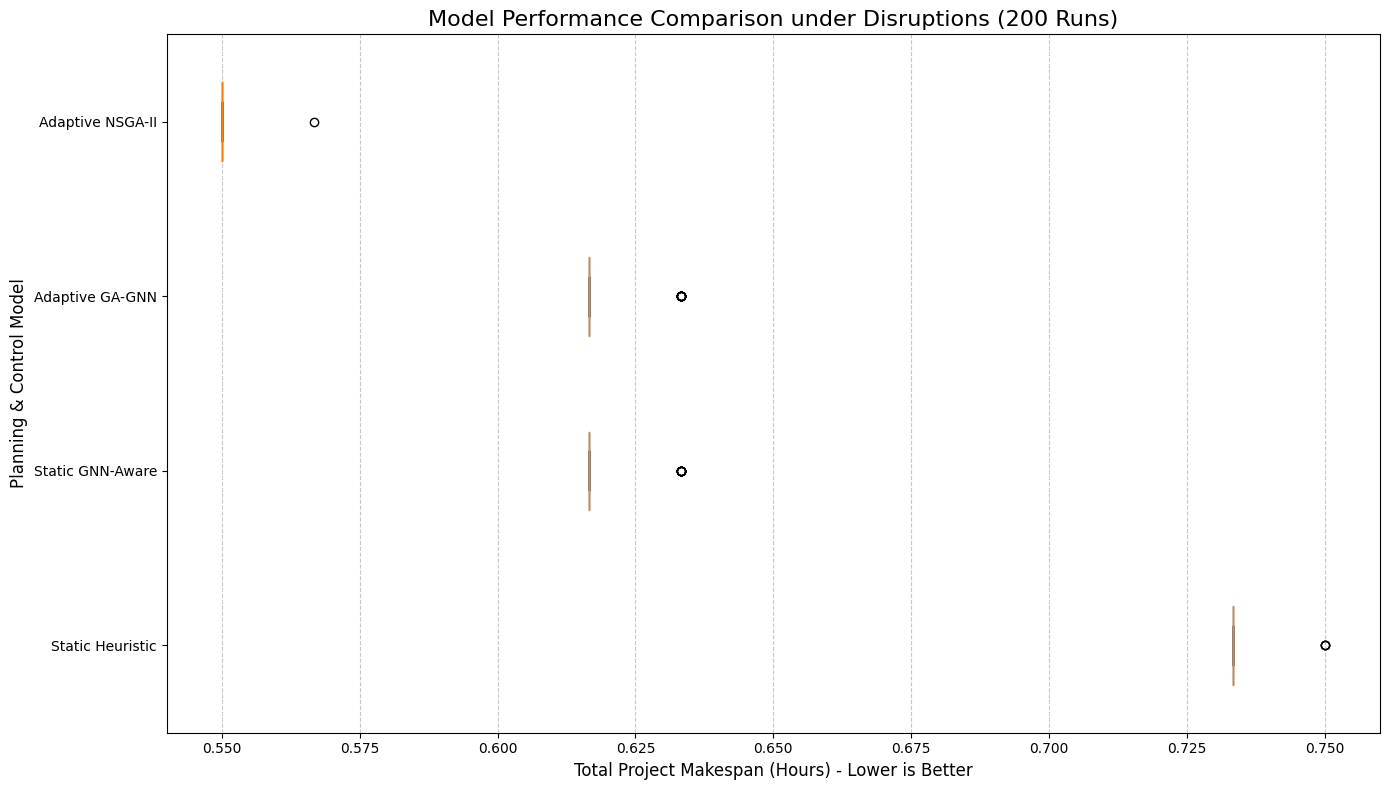

In [ ]:
import random
import matplotlib.pyplot as plt
import copy
import numpy as np
import pandas as pd
from collections import defaultdict

class ExperimentRunner:
    """
    Runs and analyzes comprehensive experiments comparing different optimization approaches,
    incorporating statistical validation over multiple simulation runs.
    """
    CO2_FACTOR = 2.68 # kg of CO2 per liter of diesel

    def __init__(self, site_graph, weather_df, simulation_manager, ground_truth_sim):
        self.site_graph = site_graph
        self.weather_df = weather_df
        self.simulation_manager = simulation_manager
        self.ground_truth_sim = ground_truth_sim # Use the high-fidelity simulator for validation
        self.NUM_SIMULATION_RUNS = config.num_simulation_runs

        self.INITIAL_VEHICLE_STATES = [
            {'id': 0, 'type': 'truck', 'location': 'Main_Gate', 'available_time': TrainingDataSimulator.SIMULATION_START_TIME},
            {'id': 1, 'type': 'truck', 'location': 'Contractor_Gate', 'available_time': TrainingDataSimulator.SIMULATION_START_TIME},
            {'id': 2, 'type': 'forklift', 'location': 'Laydown_A', 'available_time': TrainingDataSimulator.SIMULATION_START_TIME},
        ]


        self.COMPLEX_JOBS = [
            # Morning Rush - more jobs to start
            {'task': 'Deliver Rebar B1', 'sequence': [('Laydown_A', 'Building_1_N')]},
            {'task': 'Deliver Rebar B1 South', 'sequence': [('Laydown_A', 'Building_1_S')]},
            {'task': 'Clear Debris from Pit', 'sequence': [('Foundation_Pit', 'Waste_Disposal')]},
            {'task': 'Move Scaffolding to B2', 'sequence': [('Laydown_B', 'Building_2_W')]},
            {'task': 'Move Scaffolding to B1', 'sequence': [('Laydown_B', 'Building_1_S')]},
            {'task': 'Prefab Wall Delivery 1', 'sequence': [('Fabrication_Yard', 'Building_1_S')]},
            {'task': 'Prefab Wall Delivery 2', 'sequence': [('Fabrication_Yard', 'Building_2_E')]},

            # Mid-day tasks
            {'task': 'Multi-stop Debris Clearance', 'sequence': [('Building_1_S', 'Waste_Disposal'), ('Building_2_E', 'Waste_Disposal')]},
            {'task': 'Urgent Tool Delivery to Pit', 'sequence': [('Laydown_A', 'Foundation_Pit')]},
            {'task': 'Deliver Piping to B2', 'sequence': [('Laydown_A', 'Building_2_W')]},
            {'task': 'Move Soil from Pit', 'sequence': [('Foundation_Pit', 'Waste_Disposal')]},
            {'task': 'Transport Large Component', 'sequence': [('Fabrication_Yard', 'Building_2_E')]},
            {'task': 'Fuel Run for Equipment', 'sequence': [('Fuel_Depot', 'Foundation_Pit'), ('Fuel_Depot', 'Building_1_N')]},

            # Afternoon wrap-up
            {'task': 'Final Site Cleanup B2', 'sequence': [('Building_2_W', 'Waste_Disposal')]},
            {'task': 'Return unused materials', 'sequence': [('Building_1_N', 'Laydown_A')]},
        ]


        self.JOBS_FOR_PLANNING = self._flatten_jobs()

    def _flatten_jobs(self):
        jobs_for_planning = []
        for i, job in enumerate(self.COMPLEX_JOBS):
            for u, v in job['sequence']:
                jobs_for_planning.append({'id': f"{i}-{u}-{v}", 'source': u, 'destination': v})
        return jobs_for_planning

    def _run_static_optimizer(self, jobs, states, graph):
        """Simple round-robin heuristic for baseline planning."""
        print("--- Running Optimizer: Static Baseline (Round-Robin) ---")
        plan_ids = [job['id'] for job in jobs] # Simple sequential plan
        plan = [[] for _ in states]
        for i, job_id in enumerate(plan_ids):
            plan[i % len(states)].append(job_id)
        print("✅ Static optimization complete.")
        return plan, plan_ids

    def setup_disruption_scenario(self):
        """Sets up a realistic disruption scenario with weather and path closures."""
        start_time = TrainingDataSimulator.SIMULATION_START_TIME
        INITIAL_FORECAST = self.weather_df[start_time : start_time + timedelta(hours=8)]

        ground_truth_weather = self.weather_df.copy()
        storm_start = start_time + timedelta(hours=2)
        storm_end = start_time + timedelta(hours=4)
        ground_truth_weather.loc[storm_start:storm_end, 'rain'] = 8.0
        ground_truth_weather.loc[storm_start:storm_end, 'rain_intensity'] = 3
        print(f"Disruption 1: Surprise storm will occur between {storm_start.strftime('%H:%M')} and {storm_end.strftime('%H:%M')}.")

        updated_forecast = ground_truth_weather[start_time : start_time + timedelta(hours=8)]

        broken_down_graph = self.site_graph.copy()
        blocked_edge = ('Building_1_S', 'Main_Gate')
        if broken_down_graph.has_edge(*blocked_edge):
            broken_down_graph.remove_edge(*blocked_edge)
            print(f"Disruption 2: Path '{blocked_edge[0]}'->'{blocked_edge[1]}' will be blocked at {(start_time + timedelta(hours=3)).strftime('%H:%M')}.")

        simulation_events = [
            {'time': start_time + timedelta(minutes=45), 'description': "Weather Forecast Update", 'forecast_update': updated_forecast},
            {'time': start_time + timedelta(hours=3), 'description': "Site Disruption: Route Blocked", 'graph_update': broken_down_graph}
        ]
        return INITIAL_FORECAST, ground_truth_weather, simulation_events

    def run_all_experiments(self, single_obj_optimizer_aware, single_obj_optimizer_agnostic, multi_obj_optimizer):
        """Runs a full suite of experiments and collects statistical results."""
        print(f"\n✅ Starting experiment suite with {self.NUM_SIMULATION_RUNS} runs per model.")
        INITIAL_FORECAST, ground_truth_weather, simulation_events = self.setup_disruption_scenario()

        results = defaultdict(lambda: {'makespans': [], 'fuels': []})

        # --- Generate initial plans once ---
        print("\n--- Generating Initial Plans ---")
        _, static_plan_ids = self._run_static_optimizer(self.JOBS_FOR_PLANNING, self.INITIAL_VEHICLE_STATES, self.site_graph)
        aware_plan_ids, _ = single_obj_optimizer_aware.run_ga_optimizer(self.JOBS_FOR_PLANNING, self.INITIAL_VEHICLE_STATES, INITIAL_FORECAST)
        agnostic_plan_ids, _ = single_obj_optimizer_agnostic.run_ga_optimizer(self.JOBS_FOR_PLANNING, self.INITIAL_VEHICLE_STATES, INITIAL_FORECAST)

        pareto_front = multi_obj_optimizer.run_nsga2_optimizer(self.JOBS_FOR_PLANNING, self.INITIAL_VEHICLE_STATES, INITIAL_FORECAST, gnn_model_aware, self.site_graph)
        multi_obj_fastest_ids = list(pareto_front[np.argmin(np.array([ind.fitness.values for ind in pareto_front])[:, 0])]) if pareto_front else aware_plan_ids

        # --- Run Simulations for each model multiple times ---
        for i in range(self.NUM_SIMULATION_RUNS):
            print(f"\n--- Running Simulation Pass {i+1}/{self.NUM_SIMULATION_RUNS} ---")
            RandomSeedManager.set_seeds(i)

            # Define re-planning function for NSGA-II
            def replan_nsga2(jobs, states, weather):
                hof = multi_obj_optimizer.run_nsga2_optimizer(jobs, states, weather, gnn_model_aware, self.site_graph)
                best_ids = list(hof[np.argmin(np.array([ind.fitness.values for ind in hof])[:, 0])]) if hof else []
                return best_ids

            models_to_run = {
                "Static Heuristic": (static_plan_ids, None),
                "Static GNN-Aware": (aware_plan_ids, None),
                "Adaptive GA-GNN": (aware_plan_ids, single_obj_optimizer_aware.run_ga_optimizer),
                "Adaptive NSGA-II": (multi_obj_fastest_ids, replan_nsga2)
            }

            for name, (plan_ids, optimizer_func) in models_to_run.items():
                makespan, fuel = self.simulation_manager.run_adaptive_simulation(
                    plan_ids, self.JOBS_FOR_PLANNING, self.INITIAL_VEHICLE_STATES, self.site_graph,
                    ground_truth_weather, self.ground_truth_sim, optimizer_func, gnn_model_aware, True, simulation_events
                )
                results[name]['makespans'].append(makespan)
                results[name]['fuels'].append(fuel)

        return results

    def visualize_results(self, results):
        """Visualize experiment results with statistical analysis using box plots."""
        print("\n\n" + "="*70)
        print("--- 📊 FINAL PERFORMANCE ANALYSIS (Based on {} runs) 📊 ---".format(self.NUM_SIMULATION_RUNS))
        print("="*70)

        summary_data = []
        for name, data in results.items():
            mean_makespan = np.mean(data['makespans'])
            std_makespan = np.std(data['makespans'])
            mean_fuel = np.mean(data['fuels'])
            mean_co2 = mean_fuel * self.CO2_FACTOR
            print(f"{name:<25}: Makespan = {mean_makespan:.2f} ± {std_makespan:.3f} hrs | Fuel = {mean_fuel:.2f} L")
            summary_data.append({'Model': name, 'Makespan': mean_makespan, 'Fuel': mean_fuel, 'CO2': mean_co2})

        summary_df = pd.DataFrame(summary_data).sort_values('Makespan').reset_index(drop=True)
        print("\n--- Summary Table ---")
        print(summary_df.to_markdown(index=False, floatfmt=".2f"))
        print("="*70)

        labels = list(results.keys())
        data = [results[label]['makespans'] for label in labels]

        plt.figure(figsize=(14, 8))
        box = plt.boxplot(data, vert=False, patch_artist=True, labels=labels)
        colors = ['grey', 'lightcoral', 'skyblue', 'forestgreen']
        for patch, color in zip(box['boxes'], colors):
            patch.set_facecolor(color)

        plt.xlabel("Total Project Makespan (Hours) - Lower is Better", fontsize=12)
        plt.ylabel("Planning & Control Model", fontsize=12)
        plt.title(f"Model Performance Comparison under Disruptions ({self.NUM_SIMULATION_RUNS} Runs)", fontsize=16)
        plt.grid(axis='x', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

# --- Run comprehensive experiments ---
experiment_runner = ExperimentRunner(site_graph, weather_df, simulation_manager, ground_truth_sim)
results = experiment_runner.run_all_experiments(single_obj_optimizer_aware, single_obj_optimizer_agnostic, multi_obj_optimizer)
experiment_runner.visualize_results(results)


--- Generating and Analyzing Pareto Front ---
--- Running Optimizer: Multi-Objective NSGA-II ---
✅ NSGA-II optimization complete. Found 22 solutions on the Pareto front.

--- Analysis of Representative Optimal Solutions ---
Fastest Plan (Greedy Time-Minimization):
  Makespan: 0.11 hrs | Fuel Cost: 2.09 L | Risk Score: 0.86

Cheapest Plan (Fuel-Efficient / 'Green'):
  Makespan: 0.12 hrs | Fuel Cost: 2.01 L | Risk Score: 0.86

Safest Plan (Reliable / Low-Risk):
  Makespan: 0.11 hrs | Fuel Cost: 2.11 L | Risk Score: 0.40


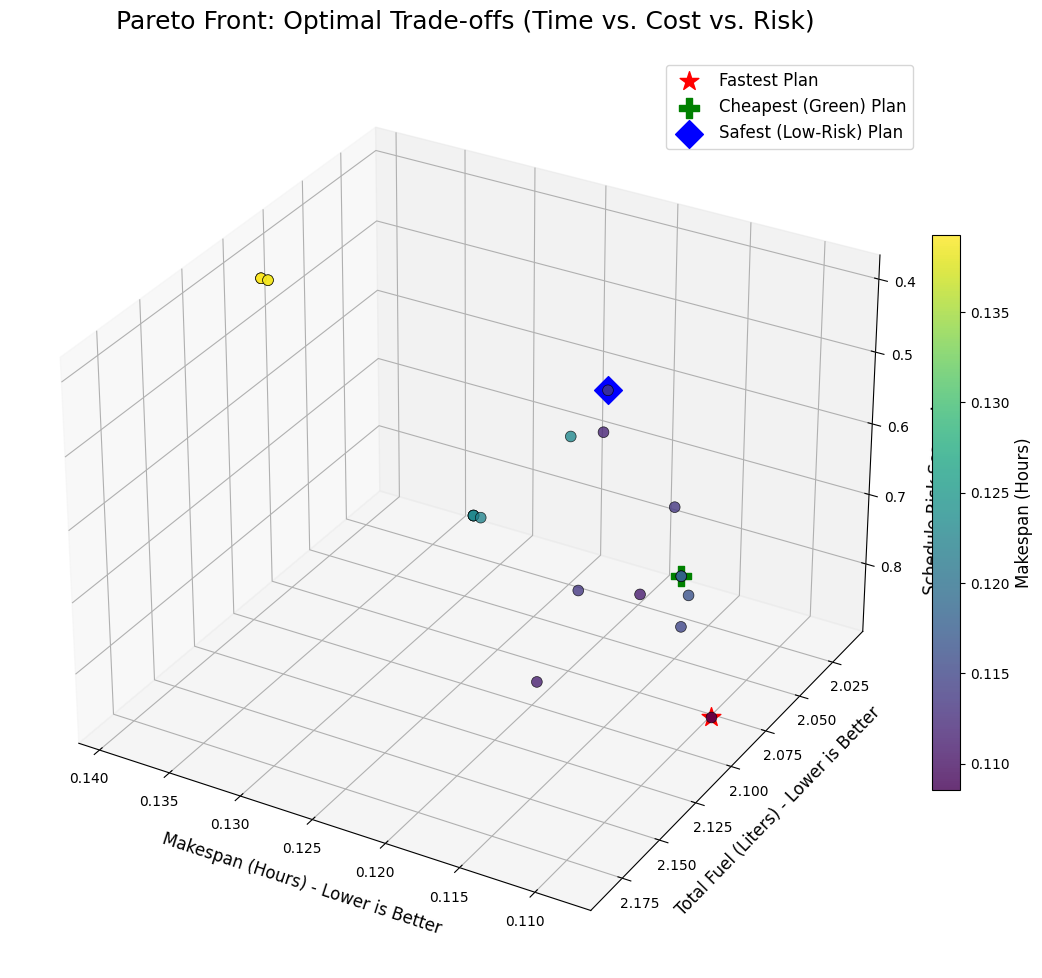



--- 🌍 Table: The Green vs. Lean Trade-Off in Construction Logistics 🌍 ---
| Metric                       |   Lean Plan (Fastest) |   Green Plan (Most Fuel-Efficient) | Trade-Off       |
|:-----------------------------|----------------------:|-----------------------------------:|:----------------|
| Project Makespan (Hours)     |                  0.11 |                               0.12 | +8.7% Time      |
| Total Fuel Consumed (Liters) |                  2.09 |                               2.01 | ---             |
| Total CO₂ Emissions (kg)     |                  5.6  |                               5.4  | -3.7% Emissions |

Key Finding: Opting for the 'Green' plan reduces CO₂ emissions by 3.7%
at the cost of a 8.7% increase in project makespan.


In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

class ParetoAnalyzer:
    """
    Analyzes and visualizes the Pareto front of solutions from the multi-objective optimizer,
    highlighting the trade-offs between time, cost (fuel), and risk.
    """

    CO2_FACTOR = 2.68 # kg of CO2 per liter of diesel

    def __init__(self, multi_obj_optimizer, jobs, states, weather_forecast, gnn_model, site_graph):
        self.multi_obj_optimizer = multi_obj_optimizer
        self.jobs = jobs
        self.states = states
        self.weather_forecast = weather_forecast
        self.gnn_model = gnn_model
        self.site_graph = site_graph

    def analyze_pareto_front(self):
        """Runs NSGA-II and analyzes the resulting Pareto front of non-dominated solutions."""
        print("\n--- Generating and Analyzing Pareto Front ---")
        pareto_front = self.multi_obj_optimizer.run_nsga2_optimizer(
            self.jobs, self.states, self.weather_forecast, self.gnn_model, self.site_graph)

        if not pareto_front:
            print("Execution Warning: No solutions were found by the NSGA-II optimizer.")
            return None

        # Extract the fitness values (Time, Fuel, Risk) from each solution
        solutions = np.array([list(ind.fitness.values) for ind in pareto_front])

        # Separate the objectives into individual arrays for analysis
        times = solutions[:, 0] / 3600.0 # Convert makespan from seconds to hours for reporting
        costs = solutions[:, 1]  # Total Fuel in Liters
        risks = solutions[:, 2]  # Sum of Variances (Risk Score)

        # Identify three key representative solutions from the front
        fastest_idx = np.argmin(times)
        cheapest_idx = np.argmin(costs)
        safest_idx = np.argmin(risks)

        # Store solutions with time converted to hours for consistent reporting
        solutions_hr = np.column_stack((times, costs, risks))
        best_time_solution = solutions_hr[fastest_idx]
        best_cost_solution = solutions_hr[cheapest_idx]
        best_risk_solution = solutions_hr[safest_idx]

        print("\n" + "="*60)
        print("--- Analysis of Representative Optimal Solutions ---")
        print("="*60)
        print(f"Fastest Plan (Greedy Time-Minimization):")
        print(f"  Makespan: {best_time_solution[0]:.2f} hrs | Fuel Cost: {best_time_solution[1]:.2f} L | Risk Score: {best_time_solution[2]:.2f}")
        print(f"\nCheapest Plan (Fuel-Efficient / 'Green'):")
        print(f"  Makespan: {best_cost_solution[0]:.2f} hrs | Fuel Cost: {best_cost_solution[1]:.2f} L | Risk Score: {best_cost_solution[2]:.2f}")
        print(f"\nSafest Plan (Reliable / Low-Risk):")
        print(f"  Makespan: {best_risk_solution[0]:.2f} hrs | Fuel Cost: {best_risk_solution[1]:.2f} L | Risk Score: {best_risk_solution[2]:.2f}")
        print("="*60)

        return pareto_front, solutions_hr, (best_time_solution, best_cost_solution, best_risk_solution)

    def visualize_pareto_3d(self, solutions, representative_solutions):
        """Creates a 3D visualization of the Pareto front."""
        times, costs, risks = solutions[:, 0], solutions[:, 1], solutions[:, 2]
        best_time, best_cost, best_risk = representative_solutions

        fig = plt.figure(figsize=(14, 12))
        ax = fig.add_subplot(111, projection='3d')

        # Create the 3D scatter plot of all solutions on the Pareto front
        scatter = ax.scatter(times, costs, risks, c=times, cmap='viridis', s=60, alpha=0.8, edgecolors='k', linewidth=0.5)

        # Highlight the representative solutions
        ax.scatter(best_time[0], best_time[1], best_time[2], c='red', s=200, marker='*', label='Fastest Plan')
        ax.scatter(best_cost[0], best_cost[1], best_cost[2], c='green', s=200, marker='P', label='Cheapest (Green) Plan')
        ax.scatter(best_risk[0], best_risk[1], best_risk[2], c='blue', s=200, marker='D', label='Safest (Low-Risk) Plan')

        ax.set_title('Pareto Front: Optimal Trade-offs (Time vs. Cost vs. Risk)', fontsize=18, pad=20)
        ax.set_xlabel('\nMakespan (Hours) - Lower is Better', fontsize=12)
        ax.set_ylabel('\nTotal Fuel (Liters) - Lower is Better', fontsize=12)
        ax.set_zlabel('\nSchedule Risk Score - Lower is Better', fontsize=12)

        # Invert axes so the ideal point (0,0,0) is in the prominent corner
        ax.invert_xaxis()
        ax.invert_yaxis()
        ax.invert_zaxis()

        cbar = fig.colorbar(scatter, shrink=0.6, aspect=20, pad=0.01)
        cbar.set_label('Makespan (Hours)', fontsize=12)
        ax.legend(fontsize=12)
        plt.show()

    def generate_green_vs_lean_table(self, representative_solutions):
        """Generates a quantitative analysis of the sustainability vs. speed trade-off."""
        best_time, best_cost, _ = representative_solutions

        # 'Lean' is the fastest plan, 'Green' is the most fuel-efficient plan
        lean_makespan, lean_fuel = best_time[0], best_time[1]
        lean_co2 = lean_fuel * self.CO2_FACTOR

        green_makespan, green_fuel = best_cost[0], best_cost[1]
        green_co2 = green_fuel * self.CO2_FACTOR

        # Calculate percentage trade-offs
        makespan_increase_pct = ((green_makespan - lean_makespan) / lean_makespan) * 100 if lean_makespan > 0 else 0
        co2_reduction_pct = ((lean_co2 - green_co2) / lean_co2) * 100 if lean_co2 > 0 else 0

        tradeoff_data = {
            'Metric': ['Project Makespan (Hours)', 'Total Fuel Consumed (Liters)', 'Total CO₂ Emissions (kg)'],
            'Lean Plan (Fastest)': [f"{lean_makespan:.2f}", f"{lean_fuel:.2f}", f"{lean_co2:.2f}"],
            'Green Plan (Most Fuel-Efficient)': [f"{green_makespan:.2f}", f"{green_fuel:.2f}", f"{green_co2:.2f}"],
            'Trade-Off': [f"+{makespan_increase_pct:.1f}% Time", "---", f"-{co2_reduction_pct:.1f}% Emissions"]
        }
        tradeoff_df = pd.DataFrame(tradeoff_data)

        print("\n\n" + "="*80)
        print("--- 🌍 Table: The Green vs. Lean Trade-Off in Construction Logistics 🌍 ---")
        print("="*80)
        print(tradeoff_df.to_markdown(index=False))
        print("="*80)
        print(f"\nKey Finding: Opting for the 'Green' plan reduces CO₂ emissions by {co2_reduction_pct:.1f}%")
        print(f"at the cost of a {makespan_increase_pct:.1f}% increase in project makespan.")

# --- Execution: Run Pareto front analysis ---
# Define the initial forecast for planning purposes
INITIAL_FORECAST = weather_df[TrainingDataSimulator.SIMULATION_START_TIME :
                             TrainingDataSimulator.SIMULATION_START_TIME + timedelta(hours=8)]

# Create experiment runner instance to easily access job and state definitions
experiment_runner_for_setup = ExperimentRunner(site_graph, weather_df, simulation_manager, ground_truth_sim)

# Initialize and run the Pareto analyzer
pareto_analyzer = ParetoAnalyzer(
    multi_obj_optimizer,
    experiment_runner_for_setup.JOBS_FOR_PLANNING,
    experiment_runner_for_setup.INITIAL_VEHICLE_STATES,
    INITIAL_FORECAST,
    gnn_model_aware,
    site_graph
)

pareto_results = pareto_analyzer.analyze_pareto_front()

# Visualize and create tables if solutions were found
if pareto_results:
    pareto_front, solutions, representative_solutions = pareto_results
    pareto_analyzer.visualize_pareto_3d(solutions, representative_solutions)
    pareto_analyzer.generate_green_vs_lean_table(representative_solutions)

--- Running Visual Verification & Sensitivity Analysis ---


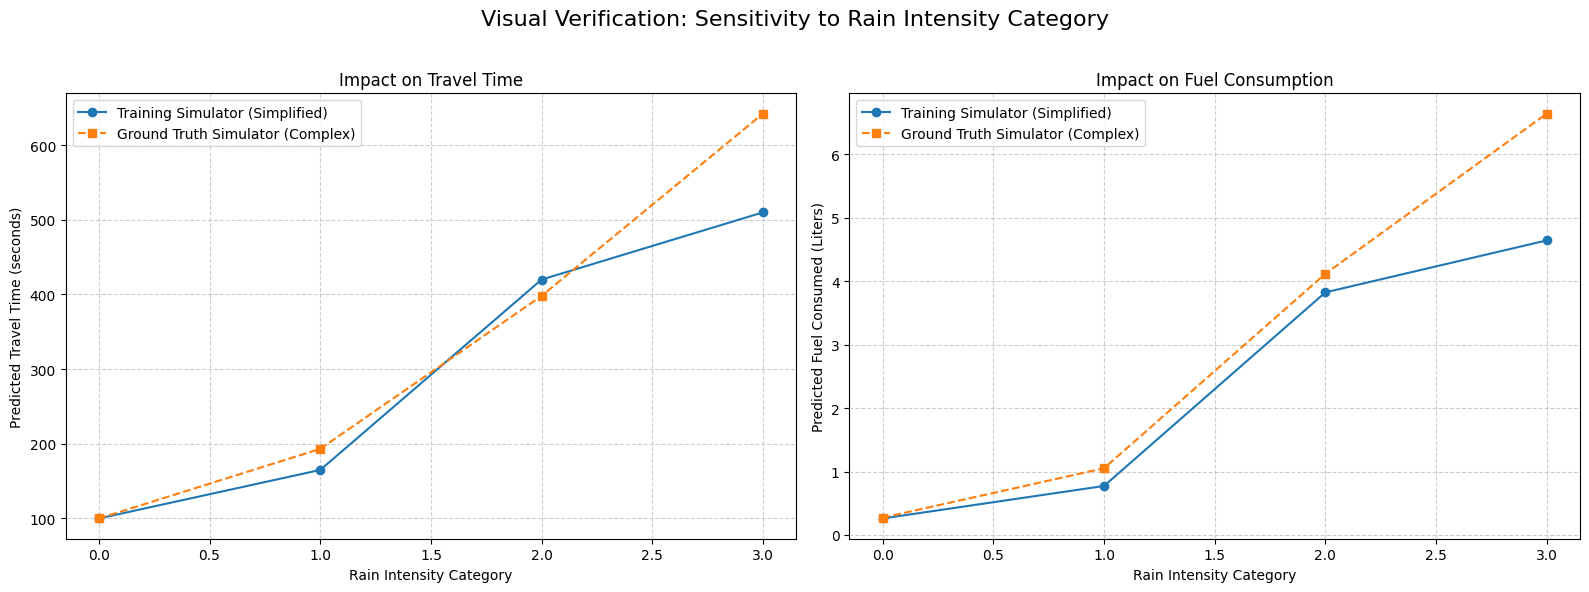

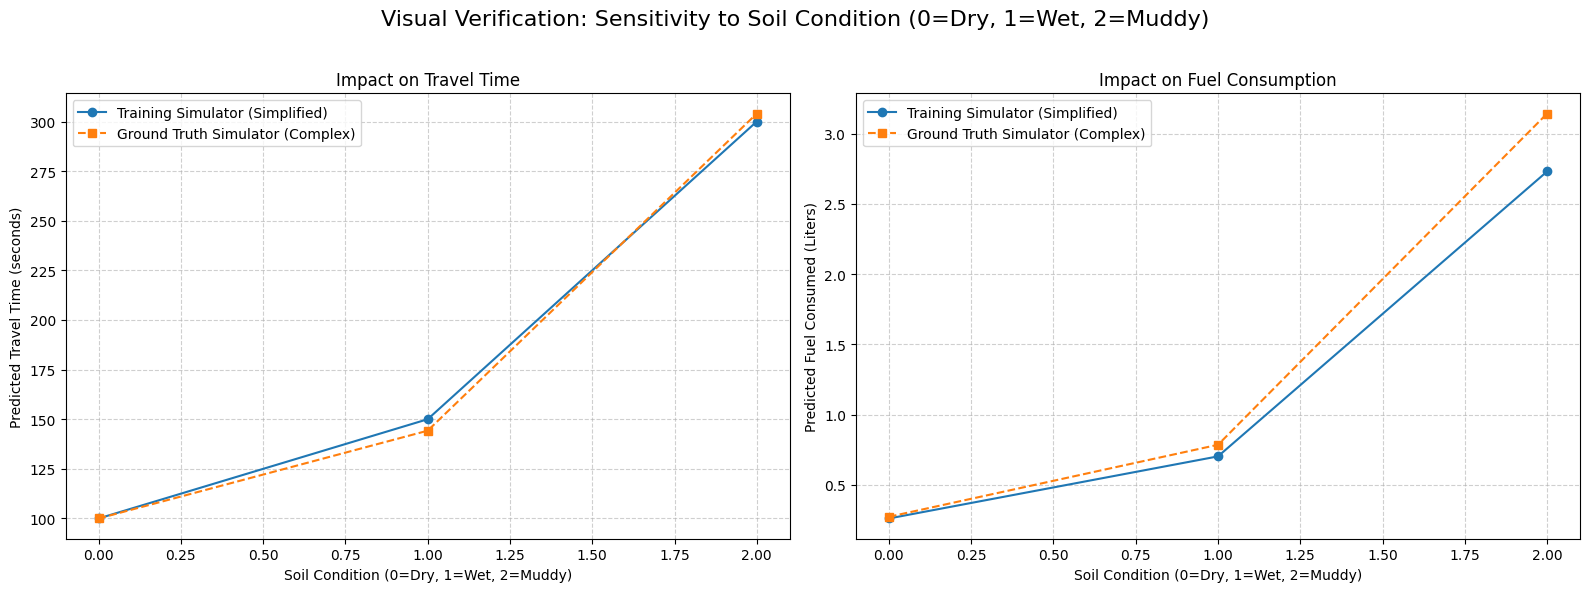

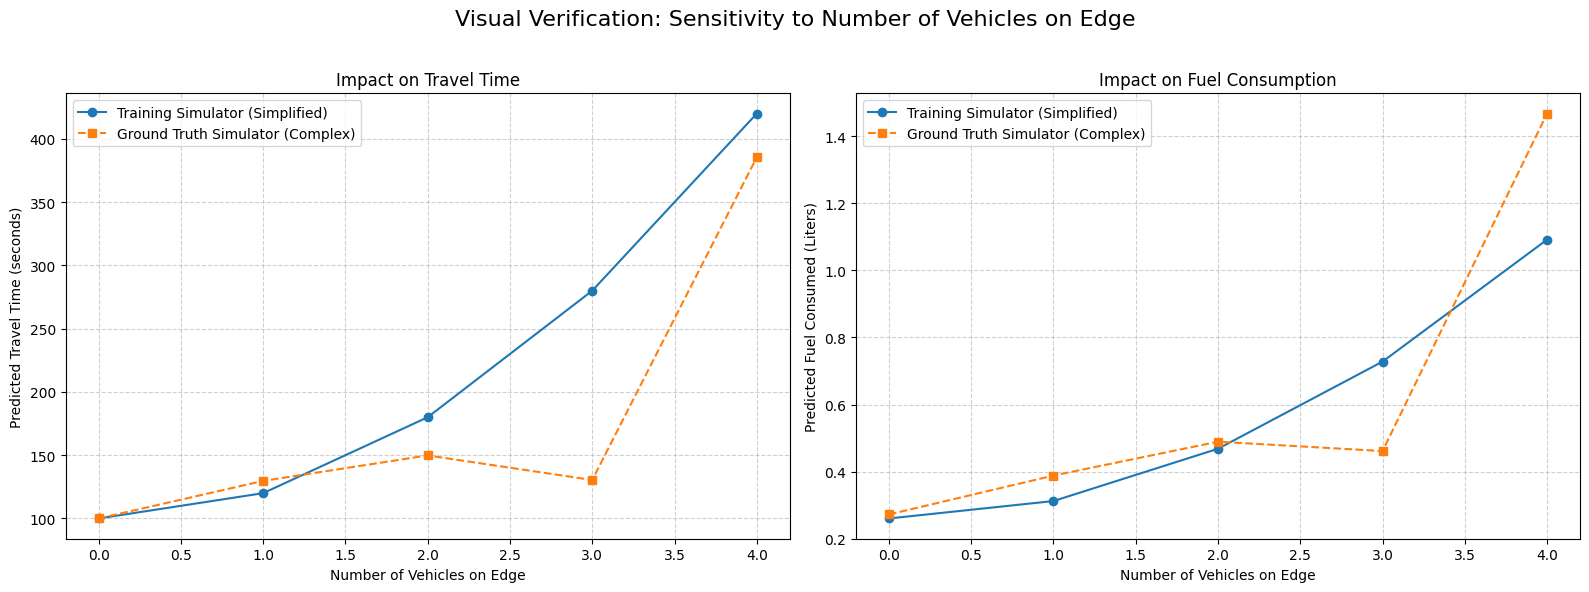

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

class VisualVerifier:
    """
    Performs sensitivity analysis to visually verify the behavior of the simulation physics engines.
    This complements unit testing by providing an intuitive understanding of the model's responses.
    """

    def __init__(self, training_sim, ground_truth_sim):
        self.training_sim = training_sim
        self.ground_truth_sim = ground_truth_sim
        self.time = datetime.now()
        self.weather = pd.Series({'rain_intensity': 0, 'heat_stress': 0, 'wind_hazard': 0})
        self.paved_edge = {'base_travel_time': 100, 'paved': True, 'slope': 2, 'start_node': 'A', 'end_node': 'B'}
        self.unpaved_edge = {'base_travel_time': 100, 'paved': False, 'slope': 2, 'start_node': 'A', 'end_node': 'B'}

    def plot_sensitivity(self, parameter_name, parameter_values, x_label):
        """
        Generic function to plot the sensitivity of model outputs to a single changing parameter.
        """
        # --- Collect data from both simulators ---
        results = {
            'Training Sim': {'time': [], 'fuel': []},
            'Ground Truth Sim': {'time': [], 'fuel': []}
        }

        for value in parameter_values:
            # Create a copy of the weather series to modify
            current_weather = self.weather.copy()

            # Update the specific parameter being tested
            if parameter_name in ['rain_intensity', 'heat_stress', 'wind_hazard']:
                current_weather[parameter_name] = value
                soil = 2 if value > 1 else (1 if value == 1 else 0)
            elif parameter_name == 'num_vehicles_on_edge':
                soil = 0 # Assume no rain for congestion test
            else:
                soil = value

            # Get results for an unpaved edge
            t_time_unpaved, _, t_fuel_unpaved = self.training_sim.calculate_travel_time(
                self.unpaved_edge, value if parameter_name == 'num_vehicles_on_edge' else 0,
                current_weather, 'truck', self.time, soil
            )
            gt_time_unpaved, _, gt_fuel_unpaved = self.ground_truth_sim.calculate_ground_truth_travel(
                self.unpaved_edge, value if parameter_name == 'num_vehicles_on_edge' else 0,
                current_weather, 'truck', self.time, soil
            )

            results['Training Sim']['time'].append(t_time_unpaved)
            results['Training Sim']['fuel'].append(t_fuel_unpaved)
            results['Ground Truth Sim']['time'].append(gt_time_unpaved)
            results['Ground Truth Sim']['fuel'].append(gt_fuel_unpaved)

        # --- Create Plots ---
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        fig.suptitle(f'Visual Verification: Sensitivity to {x_label}', fontsize=16)

        # Plot Travel Time
        ax1.plot(parameter_values, results['Training Sim']['time'], 'o-', label='Training Simulator (Simplified)')
        ax1.plot(parameter_values, results['Ground Truth Sim']['time'], 's--', label='Ground Truth Simulator (Complex)')
        ax1.set_xlabel(x_label)
        ax1.set_ylabel('Predicted Travel Time (seconds)')
        ax1.set_title('Impact on Travel Time')
        ax1.legend()
        ax1.grid(True, linestyle='--', alpha=0.6)

        # Plot Fuel Consumption
        ax2.plot(parameter_values, results['Training Sim']['fuel'], 'o-', label='Training Simulator (Simplified)')
        ax2.plot(parameter_values, results['Ground Truth Sim']['fuel'], 's--', label='Ground Truth Simulator (Complex)')
        ax2.set_xlabel(x_label)
        ax2.set_ylabel('Predicted Fuel Consumed (Liters)')
        ax2.set_title('Impact on Fuel Consumption')
        ax2.legend()
        ax2.grid(True, linestyle='--', alpha=0.6)

        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

    def run_all_verifications(self):
        """Run and plot all sensitivity analyses."""
        print("--- Running Visual Verification & Sensitivity Analysis ---")

        # 1. Sensitivity to Rain Intensity on an unpaved road
        self.plot_sensitivity('rain_intensity', [0, 1, 2, 3], 'Rain Intensity Category')

        # 2. Sensitivity to Soil Condition on an unpaved road
        self.plot_sensitivity('soil_condition', [0, 1, 2], 'Soil Condition (0=Dry, 1=Wet, 2=Muddy)')

        # 3. Sensitivity to Congestion (Number of Vehicles)
        self.plot_sensitivity('num_vehicles_on_edge', [0, 1, 2, 3, 4], 'Number of Vehicles on Edge')

# --- Execution ---
# Instantiate the simulators again, as they might not be in the global scope of this cell
training_sim_verify = TrainingDataSimulator(site_graph, weather_df, {})
ground_truth_sim_verify = GroundTruthSimulator(site_graph, weather_df, {})

visual_verifier = VisualVerifier(training_sim_verify, ground_truth_sim_verify)
visual_verifier.run_all_verifications()


--- Generating Initial Plans for Visualization ---
--- Running Optimizer: Static Baseline (Round-Robin) ---
✅ Static optimization complete.
--- Running Optimizer: Single-Objective GA (Weather-Aware: True) ---
✅ Single-objective GA optimization complete.
--- Running Optimizer: Multi-Objective NSGA-II ---
✅ NSGA-II optimization complete. Found 23 solutions on the Pareto front.


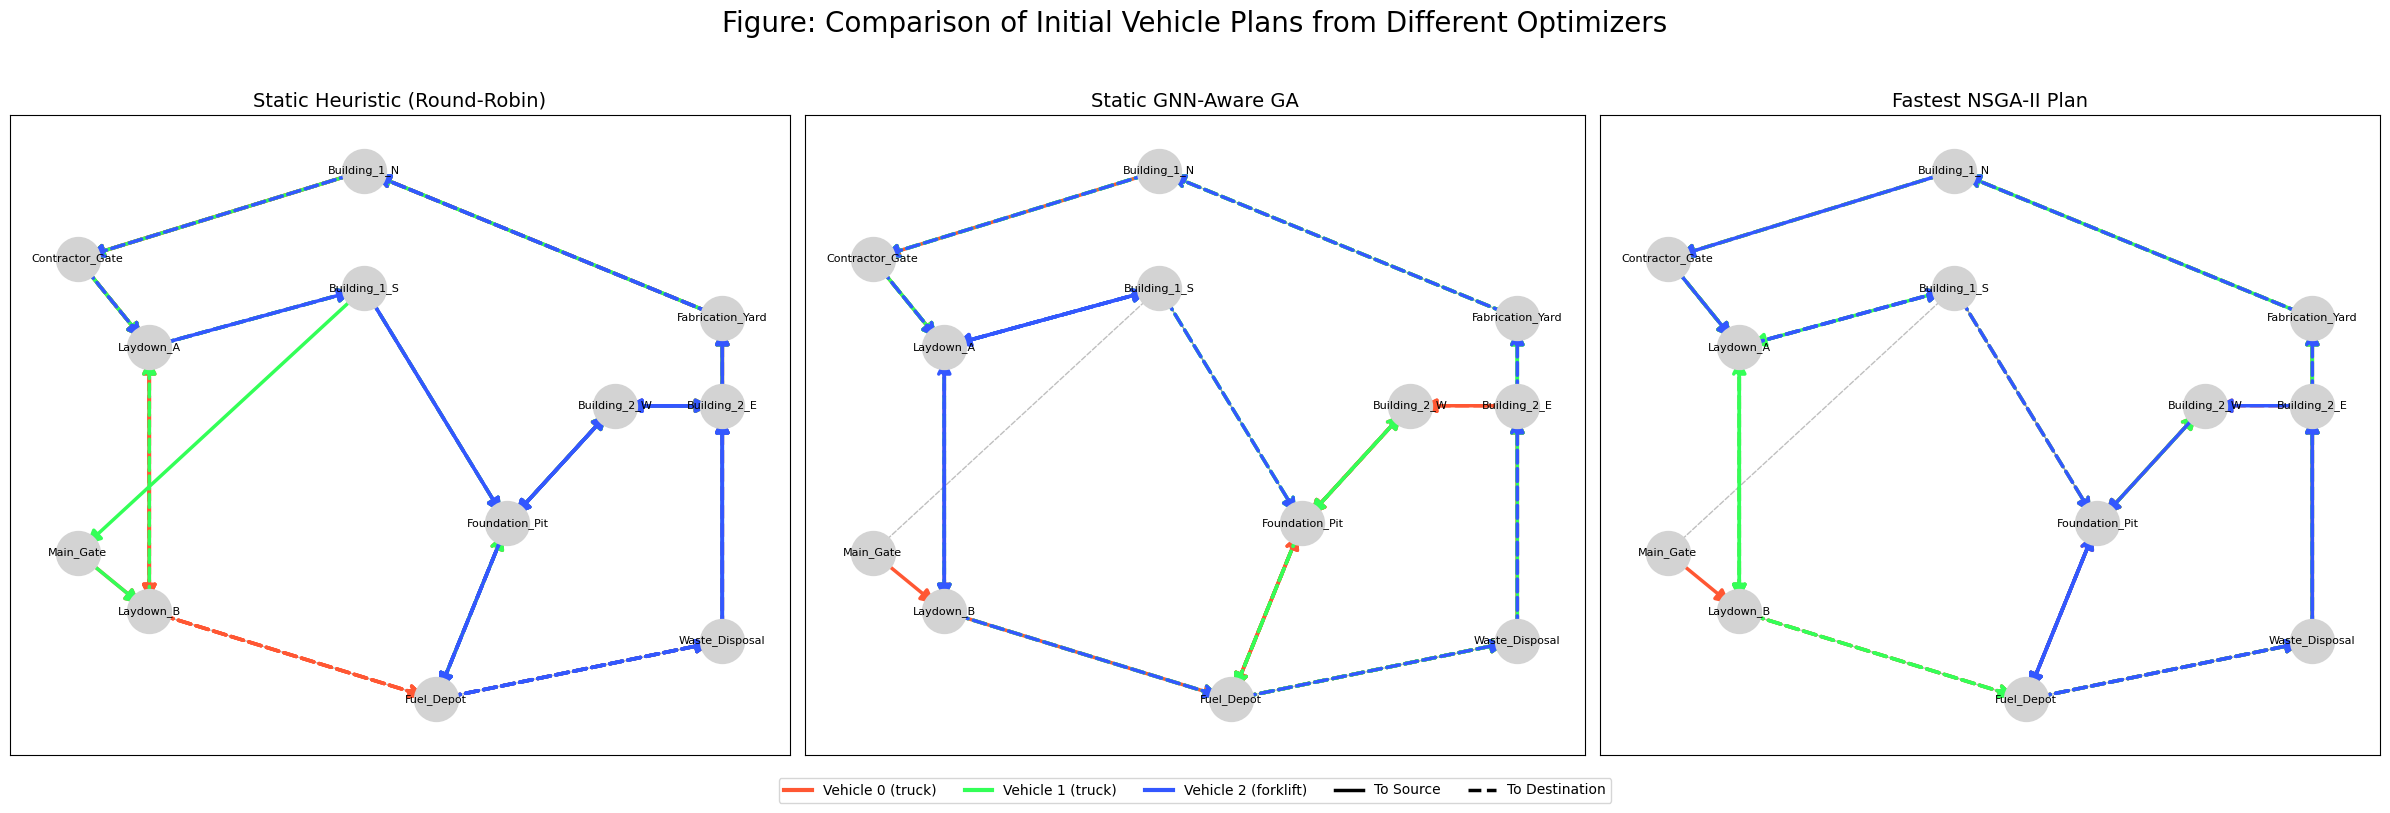

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

def visualize_initial_plans(site_graph, node_positions, jobs, static_plan_ids, aware_plan_ids, multi_obj_plan_ids, vehicle_states):
    """
    Creates a comparative plot showing the initial routes assigned to vehicles
    by different planning algorithms.
    """
    models = {
        "Static Heuristic (Round-Robin)": static_plan_ids,
        "Static GNN-Aware GA": aware_plan_ids,
        "Fastest NSGA-II Plan": multi_obj_plan_ids
    }

    num_models = len(models)
    fig, axes = plt.subplots(1, num_models, figsize=(24, 8), sharey=True)
    fig.suptitle('Figure: Comparison of Initial Vehicle Plans from Different Optimizers', fontsize=20)

    job_map = {job['id']: job for job in jobs}
    colors = ['#FF5733', '#33FF57', '#3357FF'] # Colors for Vehicle 0, 1, 2 routes

    for i, (model_name, plan_ids) in enumerate(models.items()):
        ax = axes[i]

        # Draw the base site graph
        nx.draw_networkx_nodes(site_graph, node_positions, ax=ax, node_size=1000, node_color='lightgrey')
        nx.draw_networkx_labels(site_graph, node_positions, ax=ax, font_size=8)
        nx.draw_networkx_edges(site_graph, node_positions, ax=ax, edge_color='grey', style='--', alpha=0.5)

        # Overlay the planned routes
        vehicle_routes = [[] for _ in vehicle_states]
        for j, job_id in enumerate(plan_ids):
            vehicle_routes[j % len(vehicle_states)].append(job_map[job_id])

        for v_idx, route in enumerate(vehicle_routes):
            if not route: continue

            color = colors[v_idx % len(colors)]
            current_loc = vehicle_states[v_idx]['location']

            # Draw path segments for each job
            for job in route:
                # Path to source
                path_s = nx.shortest_path(site_graph, source=current_loc, target=job['source'])
                nx.draw_networkx_edges(site_graph, node_positions, ax=ax, edgelist=list(zip(path_s, path_s[1:])),
                                       edge_color=color, width=2.5, arrowsize=20)

                # Path to destination
                path_d = nx.shortest_path(site_graph, source=job['source'], target=job['destination'])
                nx.draw_networkx_edges(site_graph, node_positions, ax=ax, edgelist=list(zip(path_d, path_d[1:])),
                                       edge_color=color, width=2.5, style='dashed', arrowsize=20)

                current_loc = job['destination']

        ax.set_title(model_name, fontsize=14)
        ax.set_xticks([])
        ax.set_yticks([])

    # Create a custom legend
    legend_elements = [plt.Line2D([0], [0], color=colors[i], lw=3, label=f'Vehicle {v_state["id"]} ({v_state["type"]})')
                       for i, v_state in enumerate(vehicle_states)]
    legend_elements.append(plt.Line2D([0], [0], color='black', lw=2.5, label='To Source'))
    legend_elements.append(plt.Line2D([0], [0], color='black', lw=2.5, ls='--', label='To Destination'))
    fig.legend(handles=legend_elements, loc='lower center', ncol=len(vehicle_states) + 2, bbox_to_anchor=(0.5, -0.02))

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# --- Execution ---
# Assumes 'experiment_runner' is already defined and has run the initial planning phase
# (This code would typically run within the ExperimentRunner or be called by it)

# We need the initial plan IDs which were generated inside ExperimentRunner
# For demonstration, we'll re-run the initial planning here.
print("\n--- Generating Initial Plans for Visualization ---")
_, static_plan_ids_viz = experiment_runner._run_static_optimizer(
    experiment_runner.JOBS_FOR_PLANNING, experiment_runner.INITIAL_VEHICLE_STATES, site_graph
)
aware_plan_ids_viz, _ = single_obj_optimizer_aware.run_ga_optimizer(
    experiment_runner.JOBS_FOR_PLANNING, experiment_runner.INITIAL_VEHICLE_STATES, INITIAL_FORECAST
)
pareto_front_viz = multi_obj_optimizer.run_nsga2_optimizer(
    experiment_runner.JOBS_FOR_PLANNING, experiment_runner.INITIAL_VEHICLE_STATES, INITIAL_FORECAST,
    gnn_model_aware, site_graph
)
multi_obj_fastest_ids_viz = list(pareto_front_viz[np.argmin(np.array([ind.fitness.values for ind in pareto_front_viz])[:, 0])])

visualize_initial_plans(site_graph, node_positions, experiment_runner.JOBS_FOR_PLANNING,
                        static_plan_ids_viz, aware_plan_ids_viz, multi_obj_fastest_ids_viz,
                        experiment_runner.INITIAL_VEHICLE_STATES)


--- Visualizing Plan Adaptation ---
--- Running Optimizer: Single-Objective GA (Weather-Aware: True) ---
✅ Single-objective GA optimization complete.
--- Running Optimizer: Single-Objective GA (Weather-Aware: True) ---
✅ Single-objective GA optimization complete.


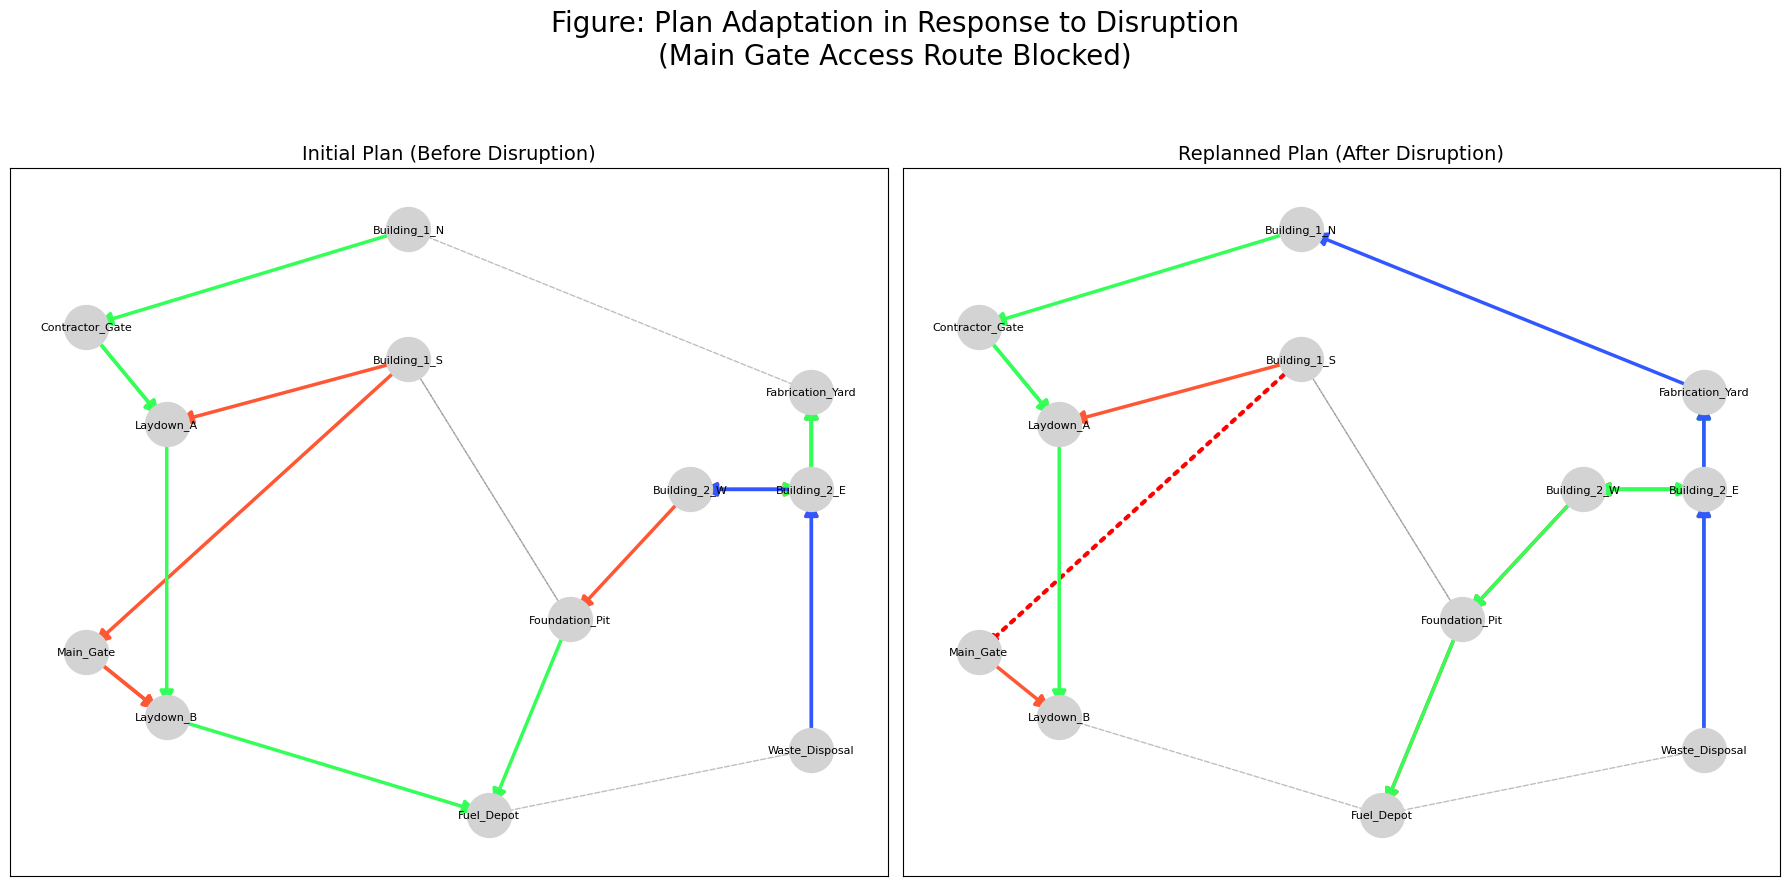

In [ ]:
def visualize_plan_adaptation(site_graph, node_positions, jobs, initial_plan_ids, replanned_plan_ids, vehicle_states, disruption_description):
    """
    Visualizes the plan before and after a major disruption, highlighting the adaptive
    re-planning capability of the digital twin.
    """
    initial_job_map = {job['id']: job for job in jobs if job['id'] in initial_plan_ids}
    replanned_job_map = {job['id']: job for job in jobs if job['id'] in replanned_plan_ids}

    fig, axes = plt.subplots(1, 2, figsize=(18, 9))
    fig.suptitle(f'Figure: Plan Adaptation in Response to Disruption\n({disruption_description})', fontsize=20)

    colors = ['#FF5733', '#33FF57', '#3357FF']

    # --- Plot 1: Initial Plan ---
    ax1 = axes[0]
    nx.draw_networkx_nodes(site_graph, node_positions, ax=ax1, node_size=1000, node_color='lightgrey')
    nx.draw_networkx_labels(site_graph, node_positions, ax=ax1, font_size=8)
    nx.draw_networkx_edges(site_graph, node_positions, ax=ax1, edge_color='grey', style='--', alpha=0.5)

    vehicle_routes_initial = [[] for _ in vehicle_states]
    for j, job_id in enumerate(initial_plan_ids):
        if job_id in initial_job_map:
            vehicle_routes_initial[j % len(vehicle_states)].append(initial_job_map[job_id])

    for v_idx, route in enumerate(vehicle_routes_initial):
        color = colors[v_idx % len(colors)]
        current_loc = vehicle_states[v_idx]['location']
        for job in route:
            path = nx.shortest_path(site_graph, source=current_loc, target=job['source'])
            nx.draw_networkx_edges(site_graph, node_positions, ax=ax1, edgelist=list(zip(path, path[1:])),
                                   edge_color=color, width=2.5, arrowsize=20)
            current_loc = job['destination']

    ax1.set_title("Initial Plan (Before Disruption)", fontsize=14)

    # --- Plot 2: Replanned Plan ---
    ax2 = axes[1]
    # Create the disrupted graph for visualization
    disrupted_graph = site_graph.copy()
    blocked_edge = ('Building_1_S', 'Main_Gate')
    if disrupted_graph.has_edge(*blocked_edge):
        disrupted_graph.remove_edge(*blocked_edge)

    nx.draw_networkx_nodes(disrupted_graph, node_positions, ax=ax2, node_size=1000, node_color='lightgrey')
    nx.draw_networkx_labels(disrupted_graph, node_positions, ax=ax2, font_size=8)
    nx.draw_networkx_edges(disrupted_graph, node_positions, ax=ax2, edge_color='grey', style='--', alpha=0.5)
    # Highlight the blocked path
    nx.draw_networkx_edges(site_graph, node_positions, ax=ax2, edgelist=[blocked_edge],
                           edge_color='red', width=3, style=':', label='Blocked Path')

    vehicle_routes_replanned = [[] for _ in vehicle_states]
    for j, job_id in enumerate(replanned_plan_ids):
        if job_id in replanned_job_map:
            vehicle_routes_replanned[j % len(vehicle_states)].append(replanned_job_map[job_id])

    for v_idx, route in enumerate(vehicle_routes_replanned):
        color = colors[v_idx % len(colors)]
        # Assume re-planning happens when vehicles are at their starting gates
        current_loc = vehicle_states[v_idx]['location']
        for job in route:
            # Re-calculate path on the DISRUPTED graph
            path = nx.shortest_path(disrupted_graph, source=current_loc, target=job['source'])
            nx.draw_networkx_edges(disrupted_graph, node_positions, ax=ax2, edgelist=list(zip(path, path[1:])),
                                   edge_color=color, width=2.5, arrowsize=20)
            current_loc = job['destination']

    ax2.set_title("Replanned Plan (After Disruption)", fontsize=14)

    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.show()

# --- Execution ---
# To generate this, we need to capture the state of the plan before and after a re-planning event.
# This requires a bit of modification to the simulation loop or a dedicated function.
# For simplicity, we'll simulate the re-planning here.

print("\n--- Visualizing Plan Adaptation ---")

# 1. Get the initial GNN-Aware plan
initial_plan_ids_adapt, _ = single_obj_optimizer_aware.run_ga_optimizer(
    experiment_runner.JOBS_FOR_PLANNING, experiment_runner.INITIAL_VEHICLE_STATES, INITIAL_FORECAST
)

# 2. Simulate re-planning on the disrupted graph
disrupted_graph_adapt = site_graph.copy()
disrupted_graph_adapt.remove_edge('Building_1_S', 'Main_Gate')

# Create a temporary optimizer with the disrupted graph
temp_optimizer = SingleObjectiveOptimizer(
    disrupted_graph_adapt, weather_df, gnn_model_aware, node_map, static_feats, edge_idx, weather_aware=True
)
replanned_ids_adapt, _ = temp_optimizer.run_ga_optimizer(
    experiment_runner.JOBS_FOR_PLANNING, experiment_runner.INITIAL_VEHICLE_STATES, INITIAL_FORECAST
)

# 3. Visualize the difference
visualize_plan_adaptation(
    site_graph, node_positions,
    experiment_runner.JOBS_FOR_PLANNING,
    initial_plan_ids_adapt,
    replanned_ids_adapt,
    experiment_runner.INITIAL_VEHICLE_STATES,
    "Main Gate Access Route Blocked"
)


\n--- Visualizing GNN Predictive Accuracy ---


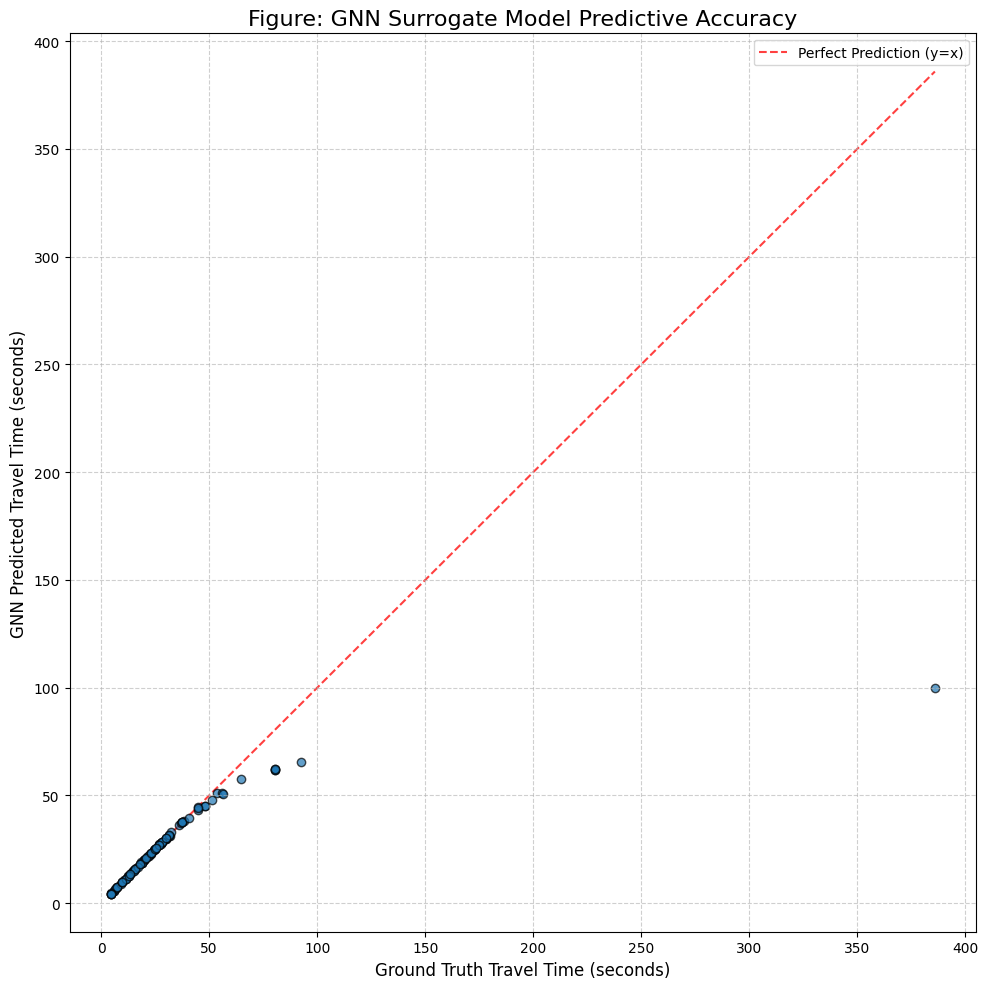

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import torch

def visualize_gnn_accuracy(gnn_model, node_mapping, static_features, edge_index, dataset_df, weather_aware=True):
    """
    Compares GNN predictions against the ground truth from the training dataset
    to visually assess the surrogate model's accuracy.
    """
    print("\\n--- Visualizing GNN Predictive Accuracy ---")

    gnn_model.eval()
    predictions = []
    ground_truths = []

    # Select a random subset of the data for visualization to keep it clean
    sample_df = dataset_df.sample(n=min(100, len(dataset_df)), random_state=42)

    for _, record in sample_df.iterrows():
        # --- This logic mirrors the GNN input creation from the trainer ---
        if weather_aware:
            dynamic_feats = [record['time_of_day'], record['num_vehicles_on_edge'], record['rain_intensity'],
                             record['heat_stress'], record['wind_hazard'], record['soil_condition'],
                             record['vehicle_type_truck']]
        else:
            dynamic_feats = [record['time_of_day'], record['num_vehicles_on_edge'], record['vehicle_type_truck']]

        dynamic_features = torch.tensor(dynamic_feats, dtype=torch.float).repeat(static_features.shape[0], 1)
        edge_attr = torch.cat([static_features, dynamic_features], dim=1)

        u, v = node_mapping[record['edge_start_node']], node_mapping[record['edge_end_node']]

        data = Data(
            x=torch.eye(len(node_mapping)),
            edge_index=edge_index,
            edge_attr=edge_attr,
            edge_label_index=torch.tensor([[u],[v]], dtype=torch.long)
        )

        with torch.no_grad():
            pred_mean, _ = gnn_model(data.x, data.edge_index, data.edge_attr, data.edge_label_index)
            predictions.append(pred_mean.item())
            ground_truths.append(record['mean_travel_time'])

    # --- Create the Scatter Plot ---
    plt.figure(figsize=(10, 10))
    plt.scatter(ground_truths, predictions, alpha=0.7, edgecolors='k')

    # Add a 45-degree line for reference (perfect prediction)
    lims = [
        min(min(ground_truths), min(predictions)),
        max(max(ground_truths), max(predictions))
    ]
    plt.plot(lims, lims, 'r--', alpha=0.75, zorder=0, label='Perfect Prediction (y=x)')

    plt.xlabel("Ground Truth Travel Time (seconds)", fontsize=12)
    plt.ylabel("GNN Predicted Travel Time (seconds)", fontsize=12)
    plt.title("Figure: GNN Surrogate Model Predictive Accuracy", fontsize=16)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

# --- Execution ---
# Assumes gnn_model_aware, node_map, static_feats, edge_idx, and dataset_df are available
visualize_gnn_accuracy(gnn_model_aware, node_map, static_feats, edge_idx, dataset_df, weather_aware=True)

In [ ]:
# --- Revised Code Chunk: GNN Accuracy Scatter Plot (Figure 11 - Compact) ---

import torch
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import random
import pandas as pd
from torch_geometric.data import Data
# (Assume generate_ground_truth_test_data is defined as before)

def visualize_gnn_gt_accuracy(gnn_model, node_mapping, static_features, edge_index, ground_truth_sim):
    """
    Creates a compact scatter plot comparing GNN predictions (μ) vs. the stochastic Ground Truth.
    """
    print("\n--- Generating Figure 11: GNN Predicted vs. Ground Truth Travel Time (Compact) ---")

    # Generate test data (limit to 500 points for a clean plot)
    test_df = generate_ground_truth_test_data(ground_truth_sim, num_samples=500)

    gnn_model.eval()
    predictions = []
    ground_truths = []

    dynamic_keys = ['time_of_day', 'num_vehicles_on_edge', 'rain_intensity', 'heat_stress',
                    'wind_hazard', 'soil_condition', 'vehicle_type_truck']

    for _, record in test_df.iterrows():
        # --- Prepare GNN Input ---
        dynamic_feats = [record[key] for key in dynamic_keys]
        dynamic_features = torch.tensor(dynamic_feats, dtype=torch.float).repeat(static_features.shape[0], 1)
        edge_attr = torch.cat([static_features, dynamic_features], dim=1)
        u, v = node_mapping[record['edge_start_node']], node_mapping[record['edge_end_node']]
        data = Data(x=torch.eye(len(node_mapping)), edge_index=edge_index, edge_attr=edge_attr,
                    edge_label_index=torch.tensor([[u],[v]], dtype=torch.long))

        with torch.no_grad():
            pred_mean, _ = gnn_model(data.x, data.edge_index, data.edge_attr, data.edge_label_index)
            predictions.append(pred_mean.item())
            ground_truths.append(record['mean_travel_time_gt'])

    # --- Create the Compact Scatter Plot (Figure 11) ---
    # Reduced figure size from (10, 10) to (7, 7)
    plt.figure(figsize=(7, 7))

    # Color points based on prediction error (for better visualization of quality)
    errors = np.abs(np.array(predictions) - np.array(ground_truths))
    plt.scatter(ground_truths, predictions, alpha=0.7, edgecolors='k', c=errors, cmap='Blues_r')

    # Calculate tight limits based on actual data
    min_val = min(min(ground_truths), min(predictions))
    max_val = max(max(ground_truths), max(predictions))

    # Add minor padding (5 seconds) to the max value
    lims = [0, max_val + 5]

    plt.plot(lims, lims, 'r--', alpha=0.75, zorder=0, label='Perfect Prediction (y=x)')

    plt.xlabel("Observed Ground Truth Travel Time (seconds)", fontsize=10)
    plt.ylabel("GNN Predicted Mean Travel Time (μ, seconds)", fontsize=10)
    # Ensure the title is concise and accurate
    plt.title("Figure 11: GNN Prediction vs. Stochastic Ground Truth", fontsize=12)

    plt.legend(fontsize=9)
    plt.grid(True, linestyle='--', alpha=0.6)

    # Apply tighter limits
    plt.xlim(lims)
    plt.ylim(lims)

    # Ensure aspect ratio is maintained
    plt.gca().set_aspect('equal', adjustable='box')

    plt.tight_layout()
    plt.show()

# --- Execution ---
# Assumes gnn_model_aware, node_map, static_feats, edge_idx, and ground_truth_sim are available
if 'gnn_model_aware' in locals() and 'ground_truth_sim' in locals():
    visualize_gnn_gt_accuracy(gnn_model_aware, node_map, static_feats, edge_idx, ground_truth_sim)
else:
    print("Dependencies not initialized. Please run training and simulation setup cells.")

ModuleNotFoundError: No module named 'torch_geometric'


--- Visualizing the Advantage of Adaptive Re-planning ---


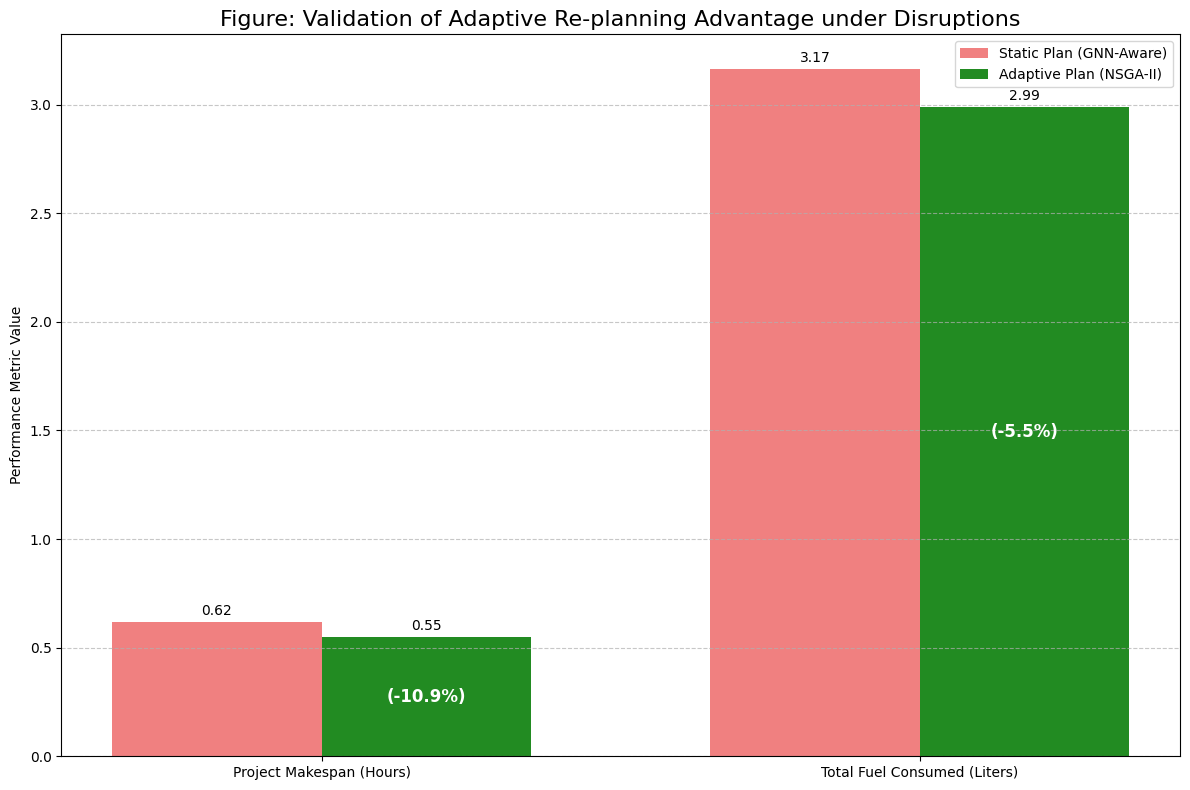


Key Validation Finding:
  - The adaptive model reduced project makespan by 10.9%.
  - The adaptive model reduced total fuel consumption by 5.5%.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_adaptive_advantage(results):
    """
    Creates a bar chart comparing the final performance of the best static plan
    versus the best adaptive plan to quantify the 'adaptive advantage'.
    """
    print("\n--- Visualizing the Advantage of Adaptive Re-planning ---")

    # --- Extract Mean Results ---
    try:
        static_makespan = np.mean(results['Static GNN-Aware']['makespans'])
        static_fuel = np.mean(results['Static GNN-Aware']['fuels'])

        # Use the best adaptive model (NSGA-II in this case) for comparison
        adaptive_makespan = np.mean(results['Adaptive NSGA-II']['makespans'])
        adaptive_fuel = np.mean(results['Adaptive NSGA-II']['fuels'])
    except KeyError:
        print("⚠️ Could not generate adaptive advantage plot: Required models not found in results.")
        return

    # Calculate percentage improvements
    makespan_improvement = ((static_makespan - adaptive_makespan) / static_makespan) * 100
    fuel_improvement = ((static_fuel - adaptive_fuel) / static_fuel) * 100

    # --- Create Bar Chart ---
    labels = ['Project Makespan (Hours)', 'Total Fuel Consumed (Liters)']
    static_values = [static_makespan, static_fuel]
    adaptive_values = [adaptive_makespan, adaptive_fuel]

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots(figsize=(12, 8))
    rects1 = ax.bar(x - width/2, static_values, width, label='Static Plan (GNN-Aware)', color='lightcoral')
    rects2 = ax.bar(x + width/2, adaptive_values, width, label='Adaptive Plan (NSGA-II)', color='forestgreen')

    # Add labels, title, and legend
    ax.set_ylabel('Performance Metric Value')
    ax.set_title('Figure: Validation of Adaptive Re-planning Advantage under Disruptions', fontsize=16)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    # Add text labels on top of the bars
    def autolabel(rects, improvement=None):
        for i, rect in enumerate(rects):
            height = rect.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')
            if improvement is not None:
                # Add the improvement percentage below the adaptive bar
                ax.annotate(f'({improvement[i]:+.1f}%)',
                            xy=(rect.get_x() + rect.get_width() / 2, height / 2),
                            ha='center', va='center', color='white', weight='bold', fontsize=12)

    autolabel(rects1)
    autolabel(rects2, improvement=[-makespan_improvement, -fuel_improvement])

    fig.tight_layout()
    plt.show()

    print(f"\nKey Validation Finding:")
    print(f"  - The adaptive model reduced project makespan by {makespan_improvement:.1f}%.")
    print(f"  - The adaptive model reduced total fuel consumption by {fuel_improvement:.1f}%.")

# --- Execution ---
# Assumes the 'results' dictionary from the ExperimentRunner is available
if 'results' in locals() and results:
    visualize_adaptive_advantage(results)
else:
    print("Please run the ExperimentRunner cell first to generate results for visualization.")


--- Visualizing GNN's Learned Understanding of Site Dynamics ---


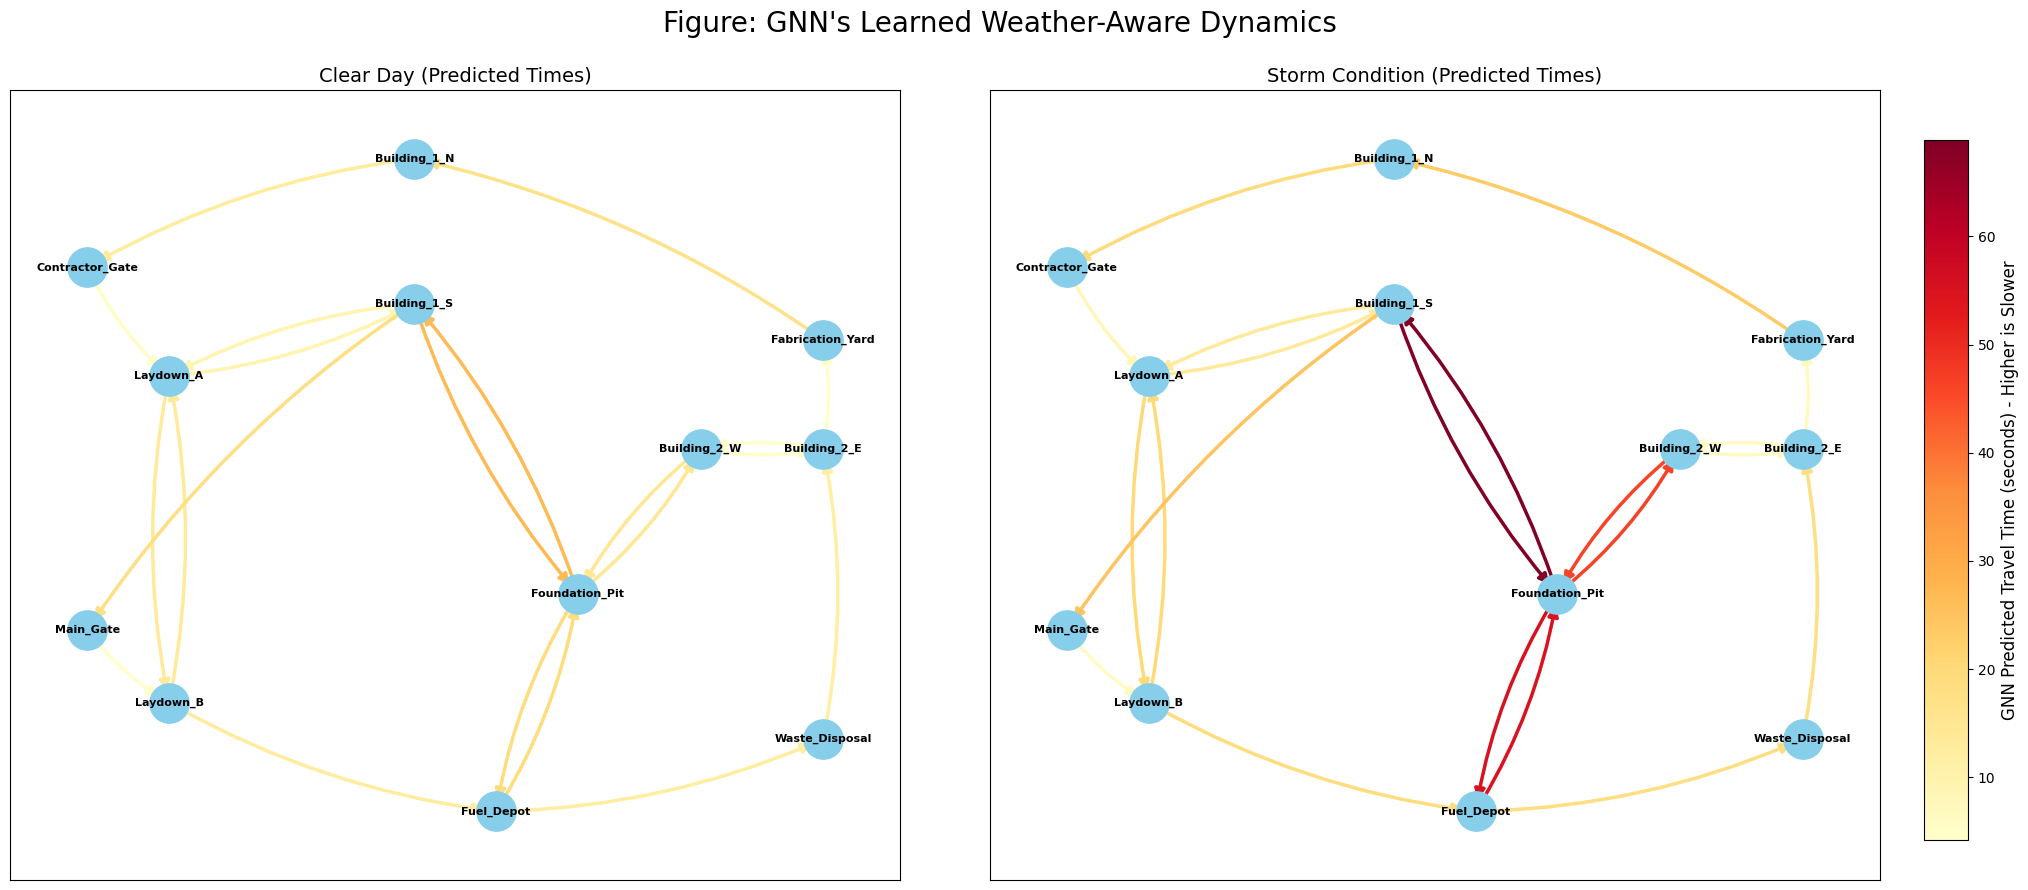

In [ ]:
# In the cell with VisualVerifier or ParetoAnalyzer (e.g., New Chunk 14)

def visualize_gnn_learned_dynamics(site_graph, node_positions, gnn_model, node_map, static_feats, edge_idx, weather_df):
    """
    Creates heatmaps of GNN-predicted travel times across the site graph under different
    weather conditions to visually validate that the model has learned weather impacts.
    (CORRECTED to fix color bar positioning).
    """
    print("\n--- Visualizing GNN's Learned Understanding of Site Dynamics ---")

    # --- Define Scenarios ---
    start_time = TrainingDataSimulator.SIMULATION_START_TIME
    clear_weather_time = start_time + timedelta(hours=1)
    storm_weather_time = start_time + timedelta(hours=3)

    weather_clear = WeatherDataManager.get_weather_at_time(clear_weather_time, weather_df)
    weather_storm = WeatherDataManager.get_weather_at_time(storm_weather_time, weather_df)

    scenarios = {
        "Clear Day (Predicted Times)": {'weather': weather_clear, 'soil': 0},
        "Storm Condition (Predicted Times)": {'weather': weather_storm, 'soil': 2}
    }

    fig, axes = plt.subplots(1, 2, figsize=(22, 10))
    fig.suptitle("Figure: GNN's Learned Weather-Aware Dynamics", fontsize=20)

    all_predicted_times = []
    all_edge_lists = []

    # --- Generate Predictions for All Edges in Each Scenario ---
    for i, (title, params) in enumerate(scenarios.items()):
        weather = params['weather']
        soil = params['soil']

        predicted_times = []
        edge_list = []

        for u_node, v_node in site_graph.edges():
            dynamic_feats = [
                10.0, 0.0, float(weather['rain_intensity']), float(weather['heat_stress']),
                float(weather['wind_hazard']),
                float(soil if not site_graph.edges[u_node, v_node].get('paved', True) else 0),
                1.0
            ]
            dynamic_features = torch.tensor(dynamic_feats, dtype=torch.float).repeat(static_feats.shape[0], 1)
            edge_attr = torch.cat([static_feats, dynamic_features], dim=1)
            u_idx, v_idx = node_map[u_node], node_map[v_node]
            data = Data(x=torch.eye(len(node_map)), edge_index=edge_idx, edge_attr=edge_attr,
                        edge_label_index=torch.tensor([[u_idx],[v_idx]], dtype=torch.long))

            gnn_model.eval()
            with torch.no_grad():
                pred_mean, _ = gnn_model(data.x, data.edge_index, data.edge_attr, data.edge_label_index)
                predicted_times.append(pred_mean.item())
                edge_list.append((u_node, v_node))

        all_predicted_times.append(predicted_times)
        all_edge_lists.append(edge_list)

    # --- Drawing Logic with Correct Colormap Normalization ---
    vmin = min(min(times) for times in all_predicted_times)
    vmax = max(max(times) for times in all_predicted_times)
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    cmap = plt.cm.YlOrRd

    for i, ax in enumerate(axes):
        nx.draw_networkx_nodes(site_graph, node_positions, ax=ax, node_size=800, node_color='skyblue')
        nx.draw_networkx_labels(site_graph, node_positions, ax=ax, font_size=8, font_weight='bold')

        edges = nx.draw_networkx_edges(
            site_graph,
            node_positions,
            ax=ax,
            edgelist=all_edge_lists[i],
            edge_color=all_predicted_times[i],
            edge_cmap=cmap,
            edge_vmin=vmin, # Set min for consistent scaling
            edge_vmax=vmax, # Set max for consistent scaling
            width=2.5,
            arrows=True,
            arrowsize=15,
            connectionstyle='arc3,rad=0.1'
        )
        ax.set_title(list(scenarios.keys())[i], fontsize=14)

    # --- CORRECTED Color Bar Setup ---
    # Create a new axis for the colorbar to the right of the subplots
    # [left, bottom, width, height] in figure coordinates
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([]) # You can pass an empty array as it's not needed for the colorbar

    cbar = fig.colorbar(sm, cax=cbar_ax)
    cbar.set_label('GNN Predicted Travel Time (seconds) - Higher is Slower', fontsize=12)

    # Use tight_layout BEFORE adding the colorbar axis to prevent overlap issues
    # We will adjust manually instead.
    fig.subplots_adjust(top=0.9, wspace=0.1, left=0.05, right=0.9)

    plt.show()

# --- Re-run the execution part of the cell to generate the fixed plot ---
if 'gnn_model_aware' in locals():
    weather_df_viz = weather_df.copy()
    viz_storm_start = TrainingDataSimulator.SIMULATION_START_TIME + timedelta(hours=2)
    viz_storm_end = TrainingDataSimulator.SIMULATION_START_TIME + timedelta(hours=4)
    weather_df_viz.loc[viz_storm_start:viz_storm_end, 'rain'] = 8.0
    weather_df_viz.loc[viz_storm_start:viz_storm_end, 'rain_intensity'] = 3

    visualize_gnn_learned_dynamics(
        site_graph, node_positions, gnn_model_aware,
        node_map, static_feats, edge_idx, weather_df_viz
    )